# Thông tin sinh viên
* Lớp: 420300411601
* Ca 1 (1: sáng, 2: chiều)
* STT: 67
* MSSV: 21120481
* Họ tên: LeQuangTuan


# Mô hình

In [13]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import plotly.graph_objects as go
import re
import tensorflow as tf
import csv
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, add
from tensorflow.keras.layers import Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from sklearn.model_selection import train_test_split
from nltk.translate.bleu_score import corpus_bleu
from PIL import Image
from tqdm import tqdm_notebook
from collections import Counter
from tqdm import tqdm 

# **InceptionV3 + LSTM + Attention (COCO2017 dataset)**

## Import data và split

### COCO2017

In [ ]:
import os
import json
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer

# Path to the COCO 2017 dataset
IMAGES_PATH = "/kaggle/input/coco-2017-dataset/coco2017/train2017"
CAPTIONS_PATH_TRAIN = "/kaggle/input/coco-2017-dataset/coco2017/annotations/captions_train2017.json"
CAPTIONS_PATH_VAL = "/kaggle/input/coco-2017-dataset/coco2017/annotations/captions_val2017.json"

# Desired image dimensions
IMAGE_SIZE = (299, 299)

# Fixed length allowed for any sequence
SEQ_LENGTH = 24


# Loads captions (text) data and maps them to corresponding images.
import json
from tqdm import tqdm

def load_captions_data(captions_json_path, max_images=100000):
    with open(captions_json_path, 'r') as caption_file:
        caption_data = json.load(caption_file)
        caption_mapping = {} # ánh xạ tên ảnh với các caption tương ứng.
        text_data = [] # danh sách toàn bộ caption (dùng cho tokenizer sau này).
        images_to_skip = set()

        images = caption_data['images'][:max_images]

        for img_info in tqdm(images, desc="Processing images"):
            img_name = img_info['file_name']
            captions = [ann['caption'] for ann in caption_data['annotations'] if ann['image_id'] == img_info['id']]

            for caption in captions:
                tokens = caption.strip().split()
                if len(tokens) < 4 or len(tokens) > SEQ_LENGTH:
                    images_to_skip.add(img_name)
                    continue

                caption = "<start> " + caption.strip() + " <end>"
                text_data.append(caption)

                if img_name in caption_mapping:
                    caption_mapping[img_name].append(caption)
                else:
                    caption_mapping[img_name] = [caption]

        for img_name in images_to_skip:
            if img_name in caption_mapping:
                del caption_mapping[img_name]

        return caption_mapping, text_data



# Splits the dataset into training, validation, and test sets
def train_val_split(caption_data, validation_size=0.2, test_size=0.02, shuffle=True):
    all_images = list(caption_data.keys())

    if shuffle:
        np.random.shuffle(all_images)

    train_keys, validation_keys = train_test_split(all_images, test_size=validation_size, random_state=42)
    validation_keys, test_keys = train_test_split(validation_keys, test_size=test_size, random_state=42)

    training_data = {img_name: caption_data[img_name] for img_name in tqdm(train_keys, desc="Processing training data")}
    validation_data = {img_name: caption_data[img_name] for img_name in tqdm(validation_keys, desc="Processing validation data")}
    test_data = {img_name: caption_data[img_name] for img_name in tqdm(test_keys, desc="Processing test data")}

    return training_data, validation_data, test_data

# Loading the dataset for COCO 2017
train_captions_mapping, train_text_data = load_captions_data(CAPTIONS_PATH_TRAIN, max_images=100000)
val_captions_mapping, val_text_data = load_captions_data(CAPTIONS_PATH_VAL)

# Spliting the dataset into train, validation, and test sets
train_data, validation_data, test_data = train_val_split(train_captions_mapping)
print(f"Total number of samples: {len(train_captions_mapping)}")
print(f"----> Number of training samples: {len(train_data)}")
print(f"----> Number of validation samples: {len(validation_data)}")
print(f"----> Number of test samples: {len(test_data)}")

## Cleaning captions

In [3]:
import re

# Hàm làm sạch caption
def clean_text(text):
    if not isinstance(text, str):
        return ""
    
    # Tạm thời giữ lại token <start> và <end>
    text = text.replace("<start>", " _start_ ").replace("<end>", " _end_ ")

    # Xử lý: loại dấu câu, số và khoảng trắng
    text = re.sub(r'[^\w\s]', '', text) # Loại bỏ dấu câu (giữ lại chữ và khoảng trắng)
    text = re.sub(r'\d+', '', text) # Loại bỏ các số
    text = re.sub(r'\s+', ' ', text).strip() # Rút gọn khoảng trắng thừa và loại bỏ khoảng trắng đầu/cuối

    # Khôi phục lại <start> và <end>
    text = text.replace("_start_", "<start>").replace("_end_", "<end>")
    
    return text

# Trích xuất text từ validation_data giống như train_text_data
val_text_data = []
for captions in validation_data.values():
    val_text_data.extend(captions)

# Gộp tất cả caption thành một danh sách
text_data = train_text_data + val_text_data

# Làm sạch caption, bỏ qua caption None
cleaned_captions = [clean_text(caption) for caption in text_data if isinstance(caption, str)]

# In kết quả mẫu
print(cleaned_captions[:15:2])


['<start> A man with a red helmet on a small moped on a dirt road <end>', '<start> A man riding on the back of a motorcycle <end>', '<start> A woman wearing a net on her head cutting a cake <end>', '<start> A woman wearing a hair net cutting a large sheet cake <end>', '<start> A woman marking a cake with the back of a chefs knife <end>', '<start> A young man holding an umbrella next to a herd of cattle <end>', '<start> A young boy with an umbrella who is touching the horn of a cow <end>', '<start> A young boy standing in front of a computer keyboard <end>']


In [4]:
# image_id<TAB>cleaned_caption

captions_IDs = []
for img_path, captions in train_captions_mapping.items():
    img_id = os.path.basename(img_path) #Lấy img_id từ đường dẫn ảnh
    for caption in captions:
        cleaned = clean_text(caption)
        item = img_id + '\t' + cleaned + '\n'
        captions_IDs.append(item)

print(captions_IDs[:20:3], len(captions_IDs))


['000000522418.jpg\t<start> A woman wearing a net on her head cutting a cake <end>\n', '000000522418.jpg\t<start> there is a woman that is cutting a white cake <end>\n', '000000184613.jpg\t<start> A young man holding an umbrella next to a herd of cattle <end>\n', '000000184613.jpg\t<start> A boy holding an umbrella while standing next to livestock <end>\n', '000000318219.jpg\t<start> He is listening intently to the computer at school <end>\n', '000000554625.jpg\t<start> a boy wearing headphones using one computer in a long row of computers <end>\n', '000000554625.jpg\t<start> Children sitting at computer stations on a long table <end>\n'] 495225


## In vài image, caption và Tokenizing

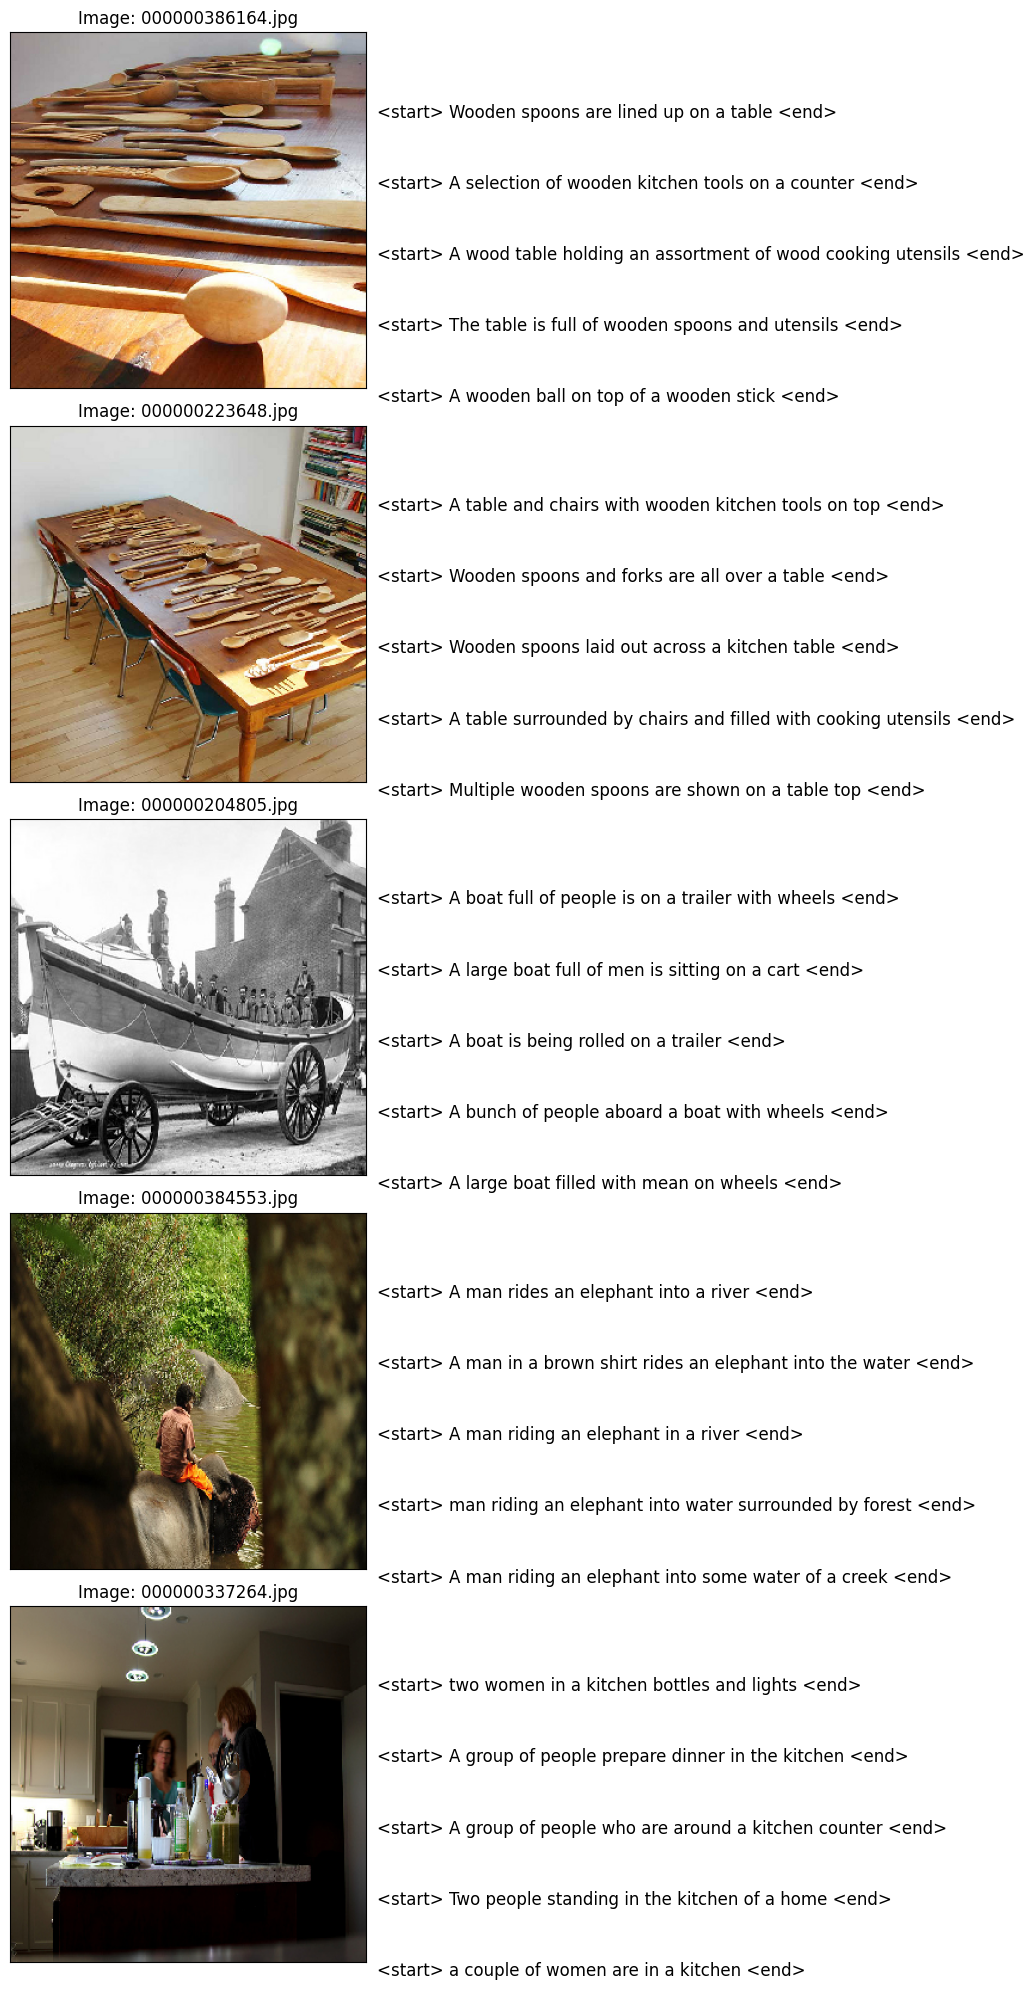

In [5]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img

def visualization(data, num_of_images, images_directory):
    # We use dictionaries to access captions of each image by its ID
    captions_dictionary = {}
    for item in data[100:100+(num_of_images)*5]:
        image_id, caption = item.split('\t')
        if image_id not in captions_dictionary:
            captions_dictionary[image_id] = []
        captions_dictionary[image_id].append(caption)
    
    # Prepare the captions data for visualization
    list_captions = [x for x in captions_dictionary.items()]
    
    count = 1
    fig = plt.figure(figsize=(12, num_of_images*4))
    
    # Loop through each image and display it along with its captions
    for filename, captions in list_captions:
        # Load the image with the specified size
        image_load = load_img(images_directory + "/" + filename, target_size=(299, 299))
        
        # Display image
        ax = fig.add_subplot(num_of_images, 2, count, xticks=[], yticks=[])
        ax.imshow(image_load)
        ax.set_title(f"Image: {filename}", fontsize=12)
        count += 1

        # Display captions
        ax = fig.add_subplot(num_of_images, 2, count)
        plt.axis('off')
        ax.set_xlim(0, 1)
        ax.set_ylim(0, len(captions))
        for i, caption in enumerate(captions):
            ax.text(0, i, caption.strip(), fontsize=12, verticalalignment='top')
        count += 1
    
    plt.tight_layout()
    plt.show()

# Example usage (ensure 'images_directory' is defined correctly)
visualization(captions_IDs, 5, IMAGES_PATH)


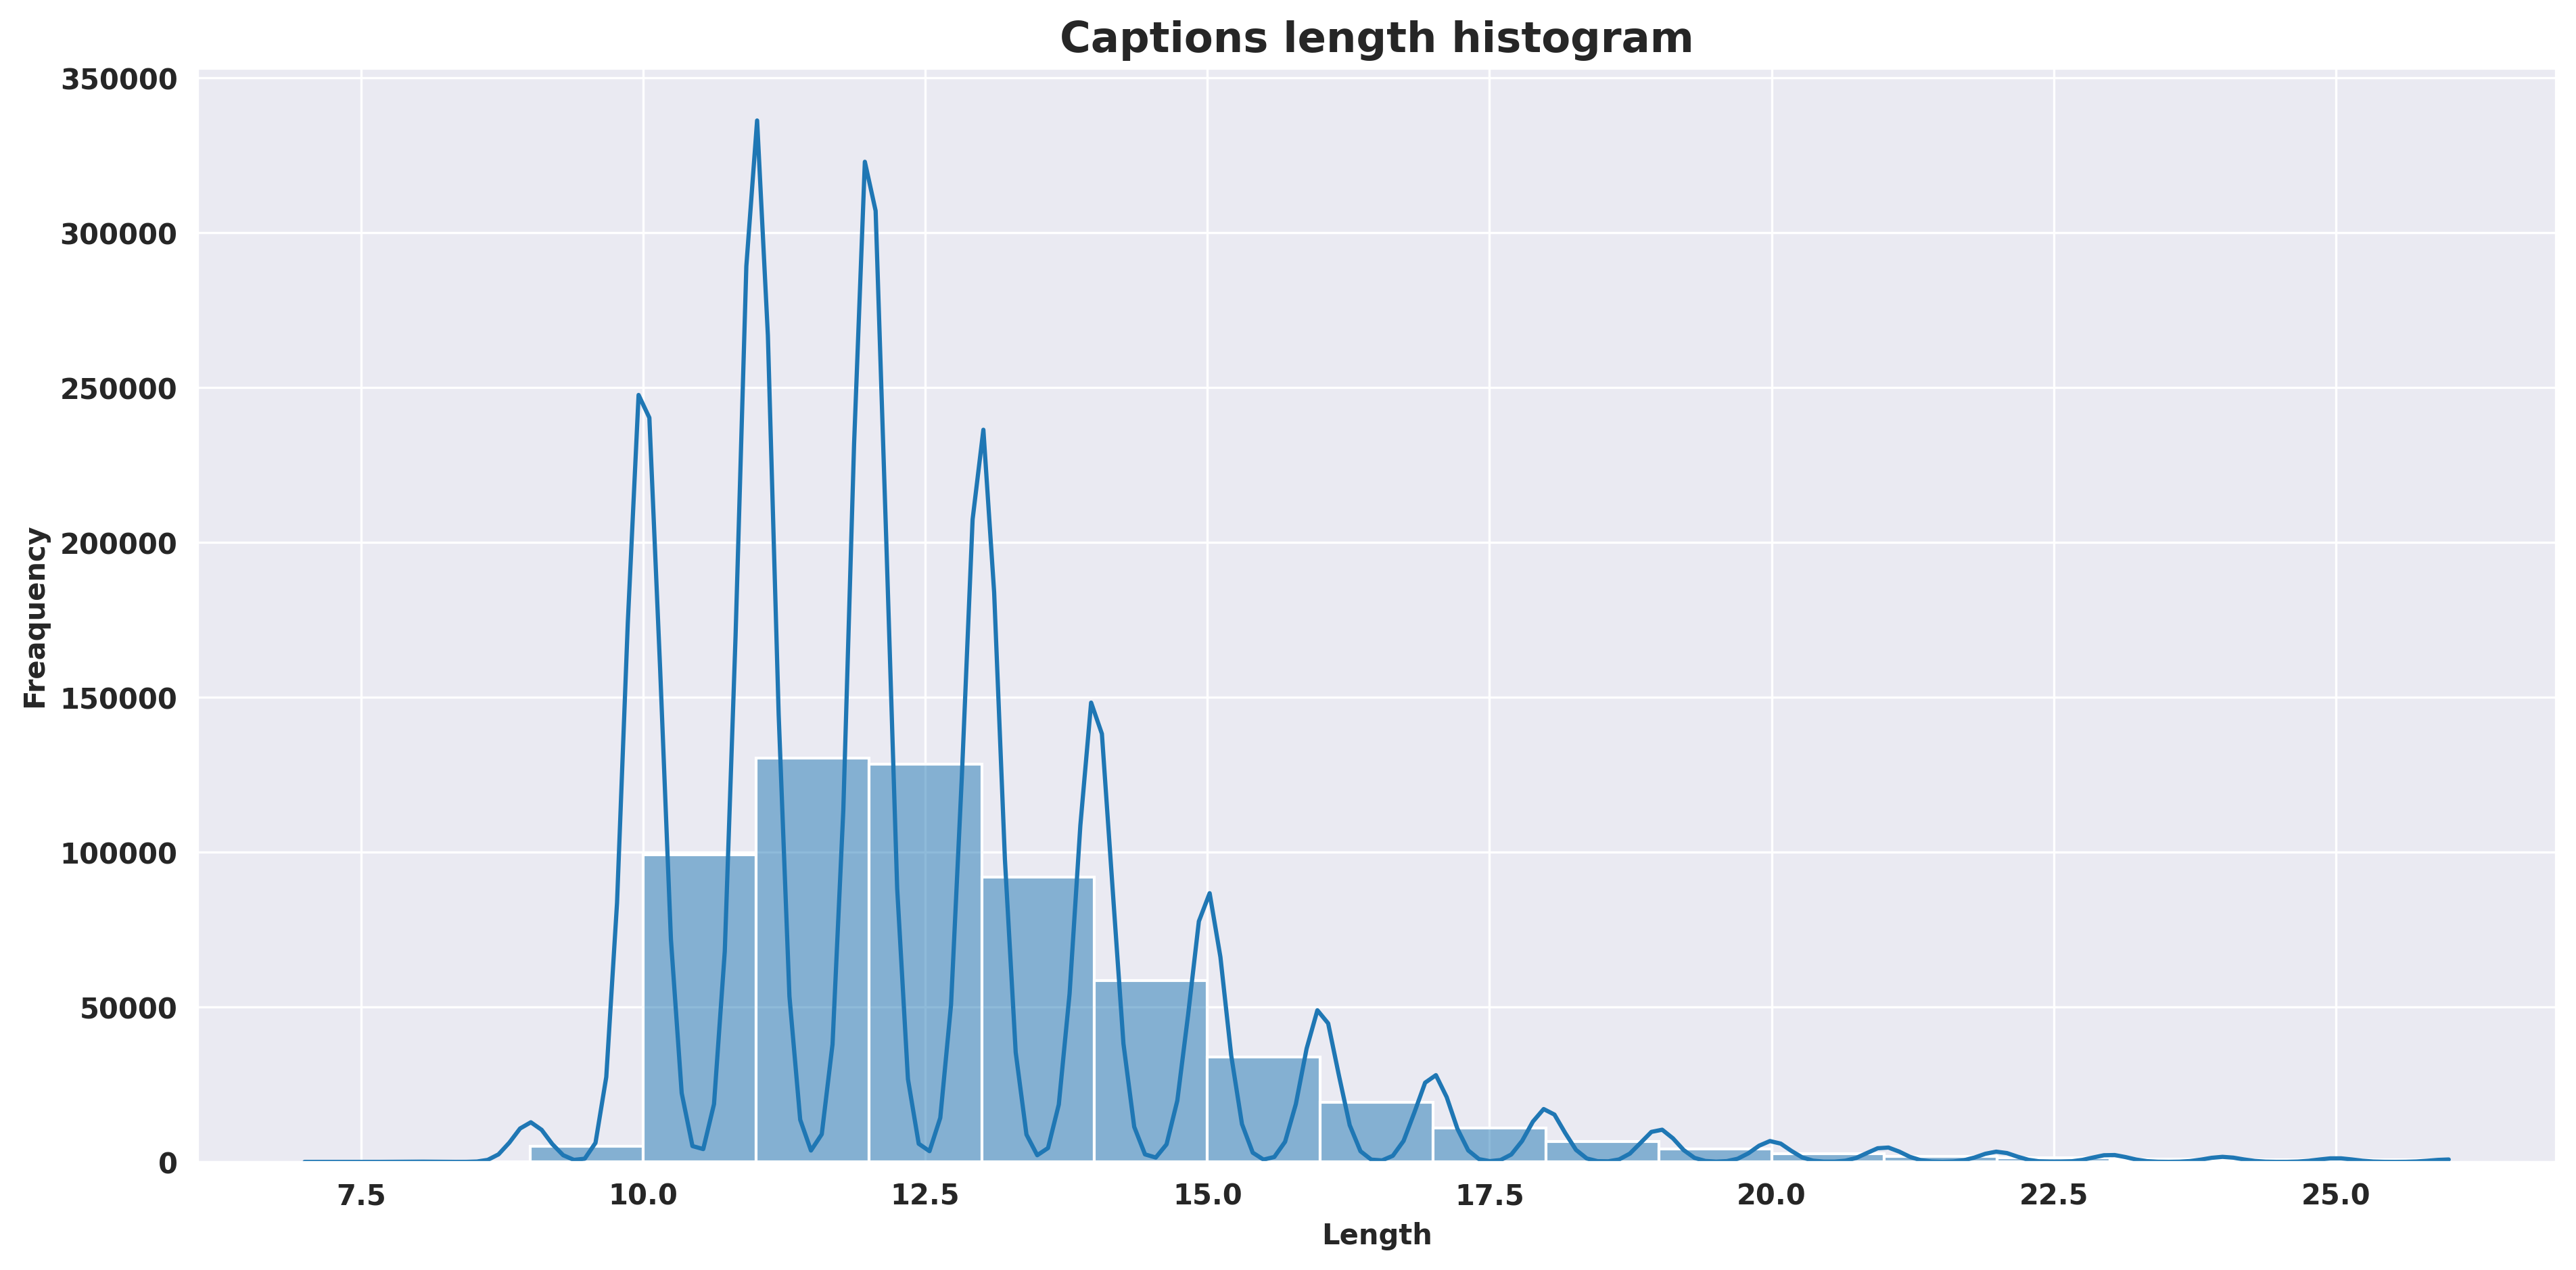

In [6]:
def captions_length(data):
    plt.figure(figsize=(15, 7), dpi=300)
    sns.set_style('darkgrid')
    sns.histplot(x=[len(x.split(' ')) for x in data], kde=True, binwidth=1) 
    plt.title('Captions length histogram', fontsize=15, fontweight='bold')
    plt.xticks(fontweight='bold')
    plt.yticks(fontweight='bold')
    plt.xlabel('Length', fontweight='bold')
    plt.ylabel('Freaquency', fontweight='bold')
    plt.show()
    
captions_length(cleaned_captions)

### Tokenizing

In [10]:
# token hóa caption
def tokenize_captions(captions):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(captions)
    return tokenizer

In [11]:
# chuyển các câu chú thích thành dãy số
tokenizer = tokenize_captions(cleaned_captions)
vocab_size = len(tokenizer.word_index) + 1
vocab_size

18824

In [12]:
import pickle

# Lưu tokenizer vào file
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [13]:
# chuyển đổi dữ liệu từ dict → list
# Tạo danh sách caption theo định dạng (image_id, caption_text)
train_captions = [(image_id, caption) for image_id, captions in train_data.items() for caption in captions]
val_captions = [(image_id, caption) for image_id, captions in validation_data.items() for caption in captions]
test_captions = [(image_id, caption) for image_id, captions in test_data.items() for caption in captions]

# Output sample
print(train_captions[0], val_captions[0], test_captions[0])
print(len(train_captions), len(val_captions), len(test_captions))


('4808904644.jpg', '<start> A woman in a white shirt and shorts walks in front of a labeled parking garage with one entrance closed . <end>') ('485245061.jpg', '<start> A man in a green jacket stands in deep snow at the base of a mountain . <end>') ('4671529065.jpg', '<start> A man with a white shirt and tattoo sits inside an ice cream stand covered with pictures of delicious treats . <end>')
121984 29789 606


## Trích xuất đặc trưng (InceptionV3)

In [14]:
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(299, 299))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0) # Thêm chiều batch (1, 299, 299, 3)
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img

def extract_image_features(model, image_path):
    img = preprocess_image(image_path)
    features = model.predict(img, verbose=0) # Dự đoán đặc trưng
    return features # (1, 2048)


inception_v3_model = InceptionV3(weights = 'imagenet', input_shape=(299, 299, 3))
inception_v3_model.layers.pop() # Loại bỏ lớp cuối cùng (tầng Dense(1000) dùng cho phân loại 1000 lớp).
inception_v3_model = Model(inputs=inception_v3_model.inputs, outputs=inception_v3_model.layers[-2].output)

I0000 00:00:1746538626.574771      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


96112376/96112376 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [ ]:
train_image_features, val_image_features, test_image_features = {}, {}, {}

# Lấy danh sách các image_id từ các bộ đã chia
train_image_ids = list(train_data.keys())
val_image_ids = list(validation_data.keys())
test_image_ids = list(test_data.keys())

# Lặp qua từng ảnh và trích xuất đặc trưng
pbar = tqdm(total=len(train_image_ids) + len(val_image_ids) + len(test_image_ids), position=0, leave=True, colour='green') 

# Trích xuất đặc trưng cho ảnh trong bộ train
for image_id in train_image_ids:
    image_path = os.path.join(IMAGES_PATH, image_id)
    image_features = extract_image_features(inception_v3_model, image_path)
    train_image_features[image_id] = image_features.flatten()  # Flattening the features
    pbar.update(1)

# Trích xuất đặc trưng cho ảnh trong bộ validation
for image_id in val_image_ids:
    image_path = os.path.join(IMAGES_PATH, image_id)
    image_features = extract_image_features(inception_v3_model, image_path)
    val_image_features[image_id] = image_features.flatten()  # Flattening the features
    pbar.update(1)

# Trích xuất đặc trưng cho ảnh trong bộ test
for image_id in test_image_ids:
    image_path = os.path.join(IMAGES_PATH, image_id)
    image_features = extract_image_features(inception_v3_model, image_path)
    test_image_features[image_id] = image_features.flatten()  # Flattening the features
    pbar.update(1)

pbar.close()


## Data Setup

In [15]:
# Hàm generator sinh dữ liệu cho mô hình học tuần tự
def data_generator(captions, image_features, tokenizer, max_caption_length, batch_size):
    num_samples = len(captions)
    while True:
        np.random.shuffle(captions)
        for start_idx in range(0, num_samples, batch_size): # Duyệt từng batch
            end_idx = min(start_idx + batch_size, num_samples)
            X_images, X_captions, y = [], [], [] 
            
            for image_id, caption_text in captions[start_idx:end_idx]:
                seq = tokenizer.texts_to_sequences([caption_text])[0]  # # Chuyển caption thành dãy số Tokenizing
                
                for i in range(1, len(seq)): # Tạo nhiều cặp input-output từ một caption
                    in_seq, out_seq = seq[:i], seq[i] # Chia chuỗi: input = [start, ..., i-1], output = i
                    
                    in_seq = pad_sequences([in_seq], maxlen=max_caption_length)[0] # Pad dãy vào cho đủ độ dài
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0] # Chuyển output thành one-hot vector
                    
                    X_images.append(image_features[image_id]) # Chuyển output thành one-hot vector
                    X_captions.append(in_seq) # Thêm chuỗi caption đã pad
                    
                    y.append(out_seq)  # Thêm nhãn (từ tiếp theo cần dự đoán)

            # Trả về một batch gồm input = [ảnh, caption], và output = từ tiếp theo
            yield [np.array(X_images), np.array(X_captions)], np.array(y)

        
# Tính độ dài lớn nhất của caption để padding
max_caption_length = max(len(caption.split()) for caption in cleaned_captions) + 1

# Kích thước vector đặc trưng ảnh đầu ra từ InceptionV3 (2048 chiều)
cnn_output_dim = inception_v3_model.output_shape[1] # 2048

# Defining batch size
#batch_size_train = 270
#batch_size_val = 150

batch_size_train = 64
batch_size_val = 32


# Creating data generators for training and validation
train_data_generator = data_generator(train_captions, train_image_features, tokenizer, max_caption_length, batch_size_train)
val_data_generator = data_generator(val_captions, val_image_features, tokenizer, max_caption_length, batch_size_val)

In [16]:
print("Kiểu dữ liệu:", type(train_captions))
if isinstance(train_captions, dict):
    first_key = next(iter(train_captions))
    print("Số lượng ảnh:", len(train_captions))
    print("Ví dụ 1 image_id:", first_key)
    print("Caption tương ứng:", train_captions[first_key][:3])  # In 3 caption đầu
elif isinstance(train_captions, list):
    print("Số lượng dòng caption:", len(train_captions))
    print("Một vài ví dụ:")
    for i in range(3):
        print(repr(train_captions[i]))
else:
    print("Cấu trúc không xác định.")


Kiểu dữ liệu: <class 'list'>
Số lượng dòng caption: 396185
Một vài ví dụ:
('000000295759.jpg', '<start> A man holding a kite string as a woman releases the kite. <end>')
('000000295759.jpg', '<start> Man and woman flying a kite together outside. <end>')
('000000295759.jpg', '<start> Group of people flying kites in a field. <end>')


In [17]:
# Checking shapes
sample_batch = next(train_data_generator)
print("Training sample batch shapes:")
print("X_images:", sample_batch[0][0].shape)
print("X_captions:", sample_batch[0][1].shape)
print("y:", sample_batch[1].shape)
print('=========================')
sample_batch = next(val_data_generator)
print("Validation sample batch shapes:")
print("X_images:", sample_batch[0][0].shape)
print("X_captions:", sample_batch[0][1].shape)
print("y:", sample_batch[1].shape)

Training sample batch shapes:
X_images: (727, 2048)
X_captions: (727, 27)
y: (727, 26923)
Validation sample batch shapes:
X_images: (357, 2048)
X_captions: (357, 27)
y: (357, 26923)


## Build Model

In [ ]:
# def build_model(vocab_size, max_caption_length, cnn_output_dim):
#     # Encoder Model
#     input_image = Input(shape=(cnn_output_dim,), name='Features_Input')
#     fe1 = BatchNormalization()(input_image)
#     fe2 = Dense(256, activation='relu')(fe1) # Adding a Dense layer to the CNN output to match the decoder output size
#     fe3 = BatchNormalization()(fe2)
    
#     # Decoder Model
#     input_caption = Input(shape=(max_caption_length,), name='Sequence_Input')
#     se1 = Embedding(vocab_size, 256, mask_zero=True)(input_caption)
#     se2 = LSTM(256, dropout=0.5)(se1)


    
#     # Output
#     decoder1 = add([fe3, se2])
#     decoder2 = Dense(256, activation='relu')(decoder1)
#     decoder2 = Dropout(0.5)(decoder2)
#     outputs = Dense(vocab_size, activation='softmax', name='Output_Layer')(decoder2)

#     # Returning The Model
#     model = Model(inputs=[input_image, input_caption], outputs=outputs, name='Image_Captioning')
#     return model
    
# # Building the model
# caption_model = build_model(vocab_size, max_caption_length, cnn_output_dim)

# optimizer = Adam(learning_rate=1e-4, clipnorm=1.0)
# caption_model.compile(loss='categorical_crossentropy', optimizer=optimizer)

# caption_model.summary()

In [20]:
from tensorflow.keras.layers import Attention, Reshape, RepeatVector, Concatenate

def build_model_with_attention(vocab_size, max_caption_length, cnn_output_dim):
    # === Encoder ===
    input_image = Input(shape=(cnn_output_dim,), name='Features_Input')  # (2048,)
    fe1 = BatchNormalization()(input_image) # Chuẩn hóa để ổn định huấn luyện
    fe2 = Dense(256, activation='relu')(fe1)  # Nén vector xuống 256 chiều
    fe3 = BatchNormalization()(fe2)
    
    # Lặp lại vector ảnh để mỗi bước thời gian đều có thông tin ảnh
    repeated_image_features = RepeatVector(max_caption_length)(fe3)  # (max_caption_length, 256)

    # === Decoder ===
    input_caption = Input(shape=(max_caption_length,), name='Sequence_Input')  # Input caption (chuỗi số token)
    se1 = Embedding(vocab_size, 256, mask_zero=True)(input_caption)  # (max_caption_length, 256)
    se2 = LSTM(256, return_sequences=True)(se1)

    # === Attention ===
    attention_output = Attention()([se2, repeated_image_features])  # (max_caption_length, 256)
    # Tính attention giữa từng bước thời gian của LSTM và đặc trưng ảnh
    # đây là dot-product attention (từ Keras)
    
    # Kết hợp đầu ra Attention và đầu ra LSTM
    decoder_combined = Concatenate()([se2, attention_output])   # Ghép theo chiều đặc trưng: (max_len, 512)
    
    # Tóm tắt theo chuỗi thời gia
    decoder_summary = tf.keras.layers.GlobalAveragePooling1D()(decoder_combined)  # (512,)
    # Gộp tất cả bước thời gian thành 1 vector duy nhất (512,)
    
    # Khởi tạo và trả về mô hình
    decoder_dense = Dense(256, activation='relu')(decoder_summary) # Tầng trung gian
    output = Dense(vocab_size, activation='softmax', name='Output_Layer')(decoder_dense)  # Dự đoán từ tiếp theo

    model = Model(inputs=[input_image, input_caption], outputs=output, name='Image_Captioning_Attention')
    return model
caption_model = build_model_with_attention(vocab_size, max_caption_length, cnn_output_dim)
caption_model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=1e-4, clipnorm=1.0))
caption_model.summary()


Model: "Image_Captioning_Attention"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Features_Input (InputLayer)    [(None, 2048)]       0           []                               
                                                                                                  
 batch_normalization_96 (BatchN  (None, 2048)        8192        ['Features_Input[0][0]']         
 ormalization)                                                                                    
                                                                                                  
 Sequence_Input (InputLayer)    [(None, 27)]         0           []                               
                                                                                                  
 dense_2 (Dense)                (None, 256)          524544      ['batch_

## Train Model


In [22]:
# Defining early stopping callback to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

def lr_scheduler(epoch, lr):
    return lr * tf.math.exp(-0.6)

# Learning Rate Scheduler
lr_schedule = LearningRateScheduler(lr_scheduler)

history = caption_model.fit(train_data_generator, steps_per_epoch=len(train_captions) // batch_size_train,
                        validation_data=val_data_generator, validation_steps=len(val_captions) // batch_size_val,
                        epochs=5, callbacks=[early_stopping, lr_schedule])

Epoch 1/5
6190/6190 [==============================] - 1374s 221ms/step - loss: 4.7101 - val_loss: 4.0888 - lr: 5.4881e-05
Epoch 2/5
6190/6190 [==============================] - 1366s 221ms/step - loss: 3.8447 - val_loss: 3.6892 - lr: 3.0119e-05
Epoch 3/5
6190/6190 [==============================] - 1347s 218ms/step - loss: 3.5486 - val_loss: 3.5351 - lr: 1.6530e-05
Epoch 4/5
6190/6190 [==============================] - 1340s 217ms/step - loss: 3.4350 - val_loss: 3.4742 - lr: 9.0718e-06
Epoch 5/5
6190/6190 [==============================] - 1350s 218ms/step - loss: 3.3847 - val_loss: 3.4462 - lr: 4.9787e-06


### Visualizing the model performance

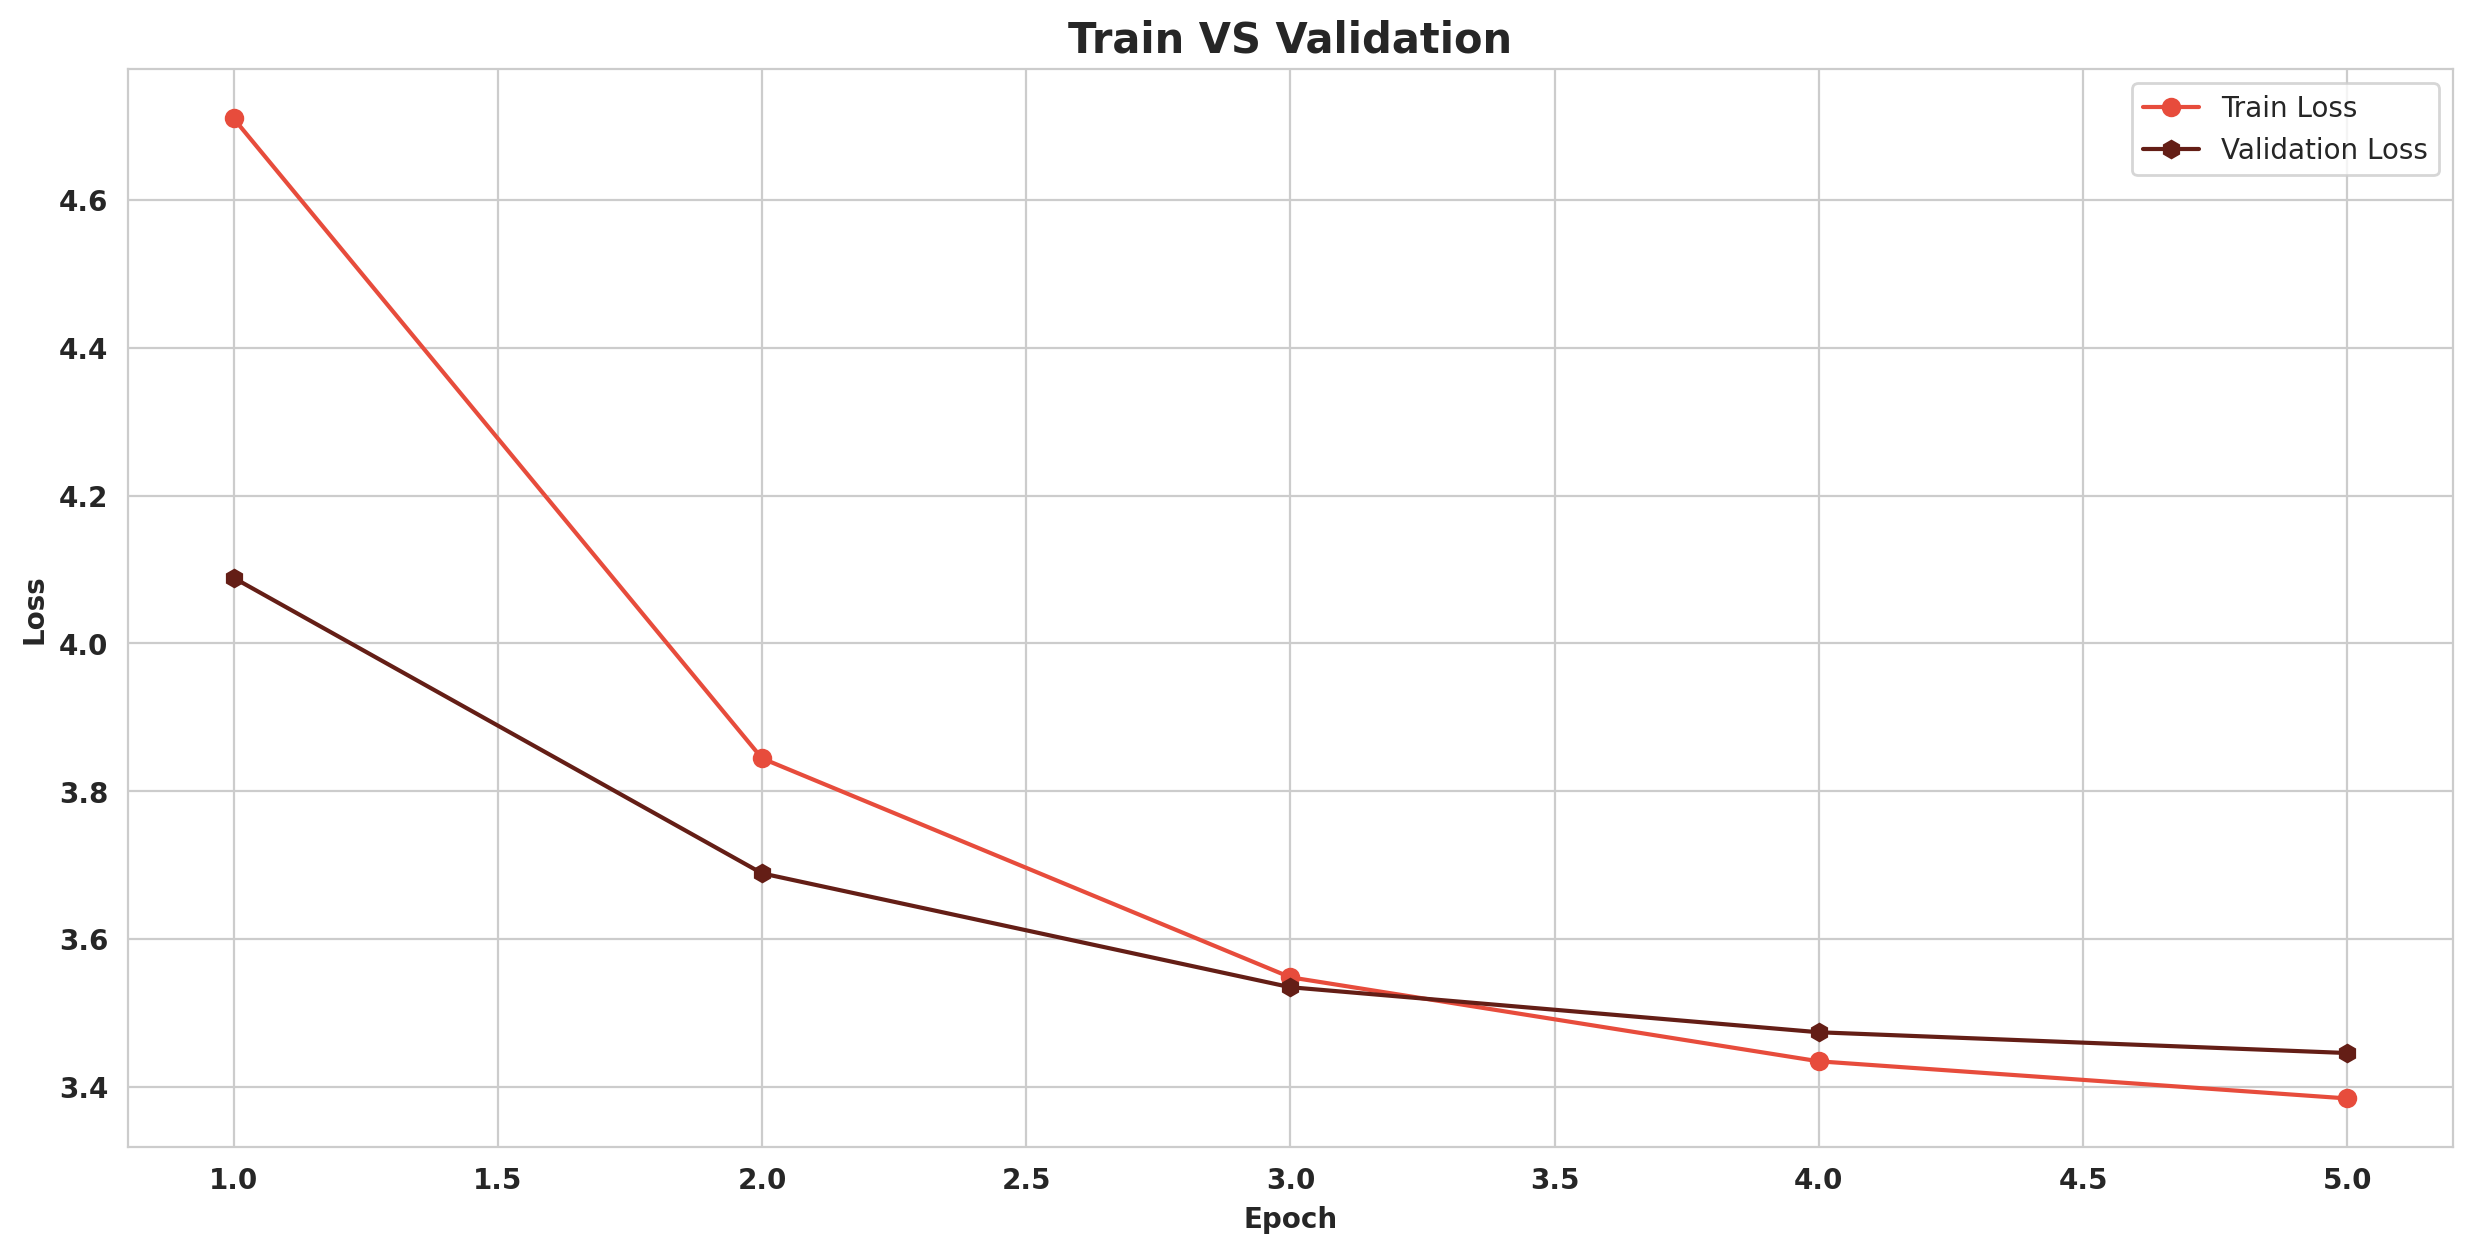

In [23]:
plt.figure(figsize=(15, 7), dpi=200)
sns.set_style('whitegrid')
plt.plot([x+1 for x in range(len(history.history['loss']))], history.history['loss'], color='#E74C3C', marker='o')
plt.plot([x+1 for x in range(len(history.history['loss']))], history.history['val_loss'], color='#641E16', marker='h')
plt.title('Train VS Validation', fontsize=15, fontweight='bold')
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')
plt.xlabel('Epoch', fontweight='bold')
plt.ylabel('Loss', fontweight='bold')
plt.legend(['Train Loss', 'Validation Loss'], loc='best')
plt.show()

In [25]:
# Lưu mô hình đã huấn luyện
caption_model.save('/kaggle/working/my_model_02.keras')


## Greedy và beam

In [26]:
def greedy_generator(image_features, max_caption_length=27): 
    in_text = 'start'
    for _ in range(max_caption_length):

        # Chuyển câu hiện tại sang dạng chuỗi token số (dựa trên tokenizer đã huấn luyện)
        sequence = tokenizer.texts_to_sequences([in_text])[0]

        # Padding sequence về độ dài cố định max_caption_length
        sequence = pad_sequences([sequence], maxlen=max_caption_length).reshape((1, max_caption_length))
        
        # Dự đoán từ tiếp theo từ mô hình dựa trên vector ảnh và câu đã có
        prediction = caption_model.predict([image_features.reshape(1, cnn_output_dim), sequence], verbose=0)
        
         # Lấy từ có xác suất cao nhất (greedy approach)
        idx = np.argmax(prediction)

        # Lấy từ tương ứng từ tokenizer, dùng get để tránh lỗi nếu không tìm thấy   
        word = tokenizer.index_word.get(idx, '')  # Dùng get tránh lỗi nếu idx không nằm trong tokenizer
        
        # Thêm từ mới vào câu đầu ra
        in_text += ' ' + word
        if word == 'end':
            break
            
    in_text = in_text.replace('start ', '')
    in_text = in_text.replace(' end', '')
    
    return in_text


In [27]:
def beam_search_generator(image_features, K_beams=3, max_caption_length=27, log=False):
    start = [tokenizer.word_index['start']]
    start_word = [[start, 0.0]]
    
    for _ in range(max_caption_length):
        temp = []
        for s in start_word:
            # Padding chuỗi để đưa vào mô hình
            sequence = pad_sequences([s[0]], maxlen=max_caption_length).reshape((1, max_caption_length))
           
            # Dự đoán từ tiếp theo
            preds = caption_model.predict([image_features.reshape(1, cnn_output_dim), sequence], verbose=0)
            
            # Lấy top-K từ có xác suất cao nhất
            word_preds = np.argsort(preds[0])[-K_beams:]
            
            for w in word_preds:
                next_cap, prob = s[0][:], s[1] # Sao chép chuỗi và xác suất hiện tại
                next_cap.append(w)

                # Cập nhật xác suất: cộng log hoặc trực tiếp tùy biến `log`
                if log:
                    prob += np.log(preds[0][w])
                else:
                    prob += preds[0][w]
                temp.append([next_cap, prob])
        # Giữ lại K_beams chuỗi tốt nhất (có xác suất cao nhất)        
        start_word = temp
        start_word = sorted(start_word, key=lambda l: l[1])[-K_beams:]
        
    # Lấy chuỗi có xác suất cao nhất trong các beam
    final_seq = start_word[-1][0]

    # Ánh xạ các số token về từ
    final_words = [tokenizer.index_word.get(i, '') for i in final_seq]

    # Loại bỏ từ 'end' nếu có
    final_caption = [w for w in final_words if w != 'end']
    
    return ' '.join(final_caption[1:])


In [28]:
def BLEU_score(actual, greedy, beam_search):
    score_greedy_1 = corpus_bleu(actual, greedy, weights=(0.3, 0.3, 0.3, 0))
    score_greedy_2 = corpus_bleu(actual, greedy, weights=(0.25, 0.25, 0.25, 0.25))
    score_BS_1 = corpus_bleu(actual, beam_search, weights=(0.3, 0.3, 0.3, 0))
    score_BS_2 = corpus_bleu(actual, beam_search, weights=(0.25, 0.25, 0.25, 0.25))

    return [
        f'BLEU-2 Greedy: {round(score_greedy_2, 5)}',
        f'BLEU-1 Greedy: {round(score_greedy_1, 5)}',
        f'BLEU-2 Beam Search: {round(score_BS_2, 5)}',
        f'BLEU-1 Beam Search: {round(score_BS_1, 5)}',
    ]

In [29]:
# A dictionary to access actual captions of each image by its ID
test_actual_captions = {}
for item in test_captions:
    image_id, caption = item  # Directly unpack the tuple
    if image_id not in test_actual_captions:
        test_actual_captions[image_id] = []
    test_actual_captions[image_id].append(caption)

In [30]:
generated_captions = {}
pbar = tqdm(total=len(test_image_features), position=0, leave=True, colour='green')
for image_id in test_image_features:
    cap = greedy_generator(test_image_features[image_id])
    generated_captions[image_id] = cap
    pbar.update(1)
pbar.close()


100%|██████████| 396/396 [03:40<00:00,  1.80it/s]


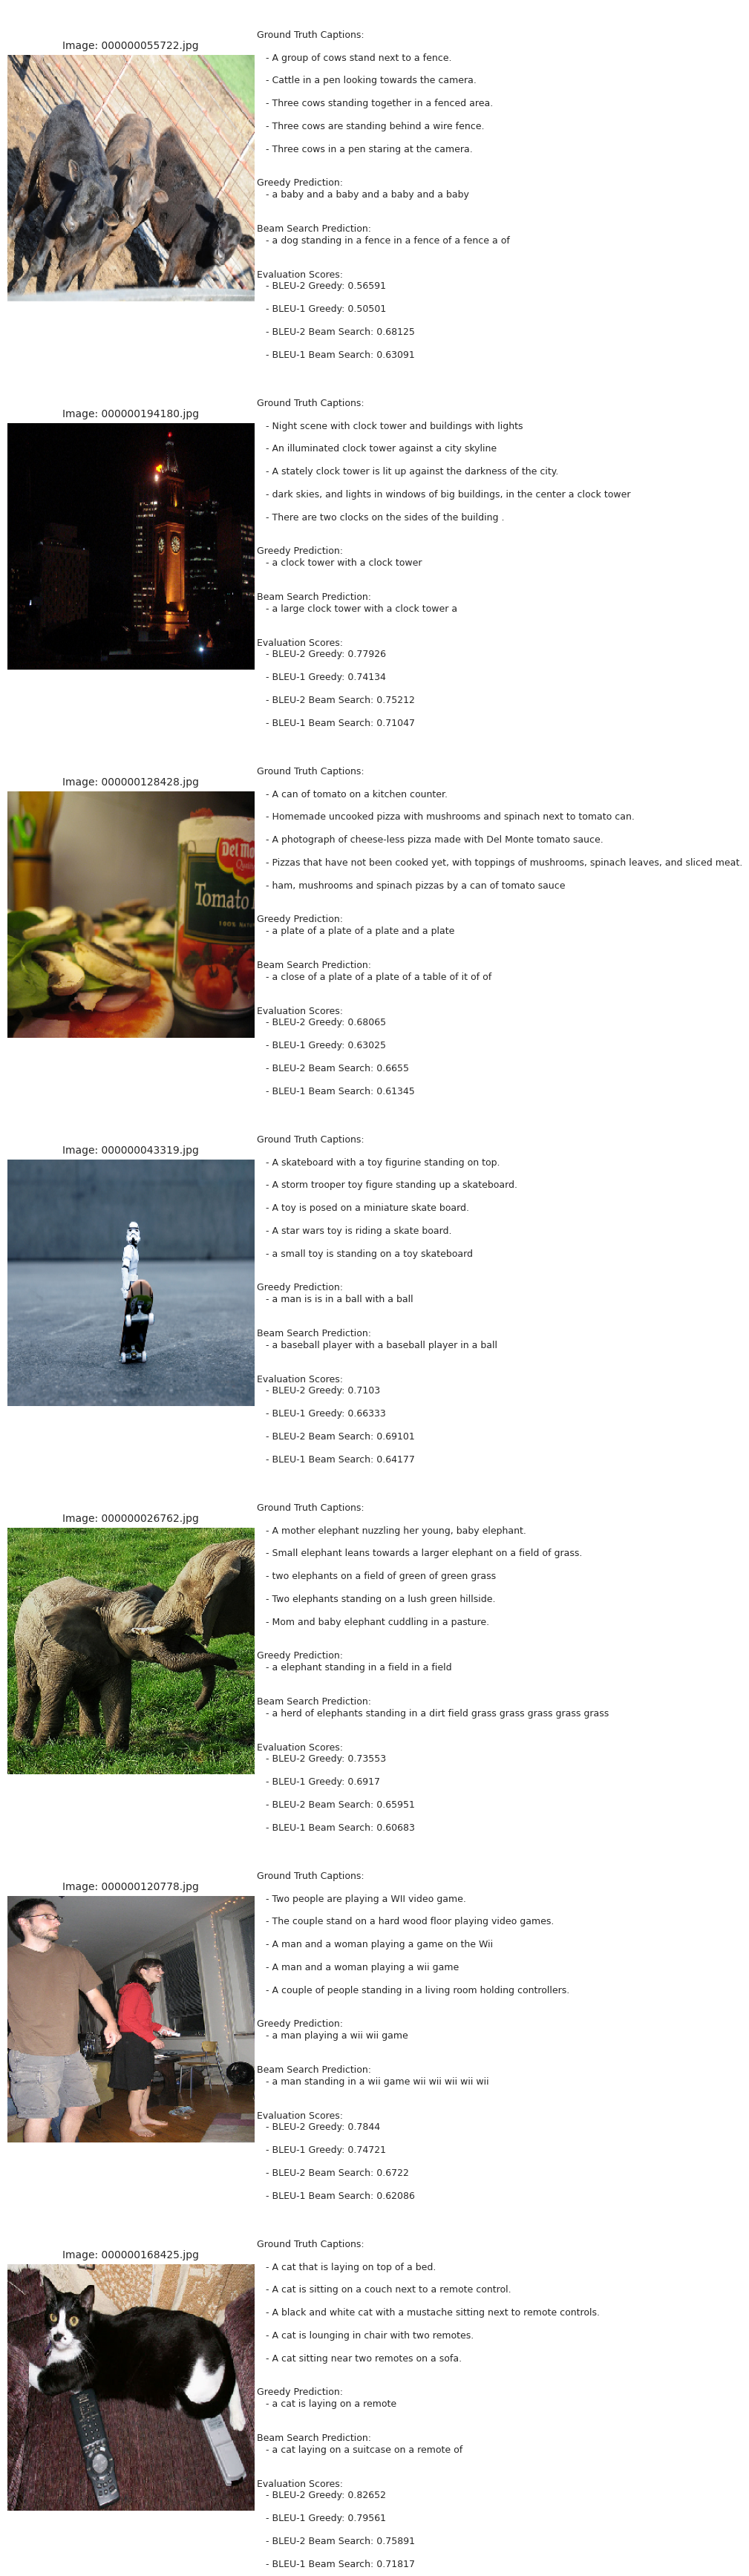

In [31]:
import matplotlib.pyplot as plt
from tensorflow.keras.utils import load_img
import os
import numpy as np

def visualization(data, greedy_caps, beamS_generator, evaluator, num_of_images=7, images_directory=''):
    keys = list(data.keys())
    images = [np.random.choice(keys) for _ in range(num_of_images)]
    
    count = 1
    fig = plt.figure(figsize=(10, 5 * num_of_images))    
    
    for filename in images:
        image_path = os.path.join(images_directory, filename)
        if not os.path.exists(image_path):
            print(f"[❌] Image not found: {image_path}")
            continue

        # Load ảnh
        try:
            image_load = load_img(image_path, target_size=(299, 299))
        except Exception as e:
            print(f"[❌] Error loading image {filename}: {e}")
            continue
        
        actual_caps = data[filename]
        actual_caps_clean = [cap.replace("<start> ", "").replace(" <end>", "") for cap in actual_caps]
        
        # Caption dự đoán
        greedy_cap = greedy_caps.get(filename, "N/A")
        beam_cap = beamS_generator(test_image_features[filename])

        # Đánh giá (nếu evaluator dùng BLEU hoặc similar)
        scores = evaluator(actual_caps_clean, [greedy_cap] * len(actual_caps_clean), [beam_cap] * len(actual_caps_clean))

        # Hiển thị ảnh
        ax = fig.add_subplot(num_of_images, 2, count)
        ax.imshow(image_load)
        ax.set_title(f"Image: {filename}", fontsize=10)
        ax.axis("off")
        count += 1

        # Hiển thị caption
        ax = fig.add_subplot(num_of_images, 2, count)
        plt.axis('off')
        text_lines = []

        text_lines.append("Ground Truth Captions:")
        text_lines.extend([f"   - {cap}" for cap in actual_caps_clean])

        text_lines.append("\nGreedy Prediction:")
        text_lines.append(f"   - {greedy_cap}")

        text_lines.append("\nBeam Search Prediction:")
        text_lines.append(f"   - {beam_cap}")

        text_lines.append("\nEvaluation Scores:")
        for score_line in scores:
            text_lines.append(f"   - {score_line}")

        ax.set_xlim(0, 1)
        ax.set_ylim(0, len(text_lines))
        for i, line in enumerate(text_lines[::-1]):
            ax.text(0, i, line, fontsize=9, va='top')

        count += 1
    
    plt.tight_layout()
    plt.show()


visualization(
    test_actual_captions, 
    generated_captions, 
    beam_search_generator, 
    BLEU_score, 
    num_of_images=7, 
    images_directory='/kaggle/input/coco-2017-dataset/coco2017/train2017'
)


In [ ]:
captions_length(list(generated_captions.values()))

In [ ]:
def visualize_single_image(image_id, actual_captions, image_features, images_directory):
    # Làm sạch actual captions
    actual_cap = actual_captions[image_id]
    actual_cap = [x.replace("start ", "").replace(" end", "") for x in actual_cap]

    # Tạo captions dự đoán
    greedy_cap = greedy_generator(image_features[image_id])
    beamS_cap = beam_search_generator(image_features[image_id])

    # Tính BLEU score
    scores = BLEU_score(actual_cap, [greedy_cap] * len(actual_cap), [beamS_cap] * len(actual_cap))

    # Load và hiển thị ảnh
    image_path = os.path.join(images_directory, image_id)
    image = load_img(image_path, target_size=(199, 199, 3))

    # Vẽ ảnh
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.axis('off')
    plt.title("Ảnh cần sinh chú thích")
    plt.show()

    # In kết quả
    print("Actual Captions:")
    for cap in actual_cap:
        print("-", cap)
    
    print("\nPredicted Captions & BLEU Scores:")
    for s in scores:
        print("-", s)


In [ ]:
images_directory = '/kaggle/input/coco-2017-dataset/coco2017/train2017/'
image_id = list(test_actual_captions.keys())[0]  # hoặc chọn cụ thể ID nếu muốn

visualize_single_image(image_id, test_actual_captions, test_image_features, images_directory)


In [35]:
!pip install sacrebleu --quiet

## Test


Ảnh: /kaggle/input/testck/Picture1.jpg


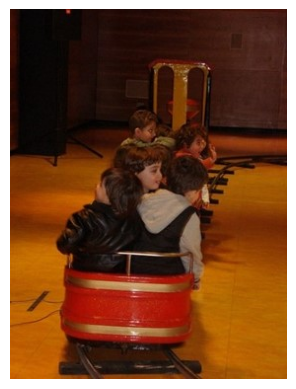


Caption thực tế: “some children are riding on a mini orange train
Greedy Caption : a group of people sitting on a room
Beam Caption   : a group of people sitting on a living room

🔍 BLEU-2 Score:
   - Greedy     : 0.3536
   - Beam Search: 0.3333


In [42]:
from tensorflow.keras.models import load_model
import pickle
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.translate.bleu_score import corpus_bleu
import numpy as np
import matplotlib.pyplot as plt

# Load mô hình và tokenizer
caption_model = load_model('/kaggle/working/my_model_02.keras')
with open('/kaggle/working/tokenizer.pickle', 'rb') as f:
    tokenizer = pickle.load(f)
cnn_output_dim = 2048

# Load CNN để trích đặc trưng
base_model = InceptionV3(weights='imagenet')
cnn_model = Model(base_model.input, base_model.layers[-2].output)

# Hàm trích đặc trưng ảnh
def extract_features(image_path):
    img = load_img(image_path, target_size=(299, 299))
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    features = cnn_model.predict(x, verbose=0)
    return features.reshape(-1)

# Hàm sinh caption Greedy
def greedy_generator(image_features, max_caption_length=27): 
    in_text = 'start'
    for _ in range(max_caption_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_caption_length).reshape((1, max_caption_length))
        prediction = caption_model.predict([image_features.reshape(1, cnn_output_dim), sequence], verbose=0)
        idx = np.argmax(prediction)
        word = tokenizer.index_word.get(idx, '')  # Dùng get tránh lỗi nếu idx không nằm trong tokenizer
        in_text += ' ' + word
        if word == 'end':
            break
    in_text = in_text.replace('start ', '').replace(' end', '')
    return in_text

# Hàm sinh caption Beam Search
def beam_search_generator(image_features, K_beams=3, max_caption_length=27):
    start = [tokenizer.word_index['start']]
    start_word = [[start, 0.0]]
    
    for _ in range(max_caption_length):
        temp = []
        for s in start_word:
            sequence = pad_sequences([s[0]], maxlen=max_caption_length).reshape((1, max_caption_length))
            preds = caption_model.predict([image_features.reshape(1, cnn_output_dim), sequence], verbose=0)
            word_preds = np.argsort(preds[0])[-K_beams:]
            
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += np.log(preds[0][w])
                temp.append([next_cap, prob])
                
        start_word = sorted(temp, key=lambda l: l[1])[-K_beams:]
    
    final_seq = start_word[-1][0]
    final_words = [tokenizer.index_word.get(i, '') for i in final_seq]
    final_caption = [w for w in final_words if w != 'end']
    
    return ' '.join(final_caption[1:])

# Hàm BLEU
def BLEU_score(actual, greedy, beam_search):
    score_greedy = corpus_bleu([actual], [greedy], weights=(0.5, 0.5))
    score_beam = corpus_bleu([actual], [beam_search], weights=(0.5, 0.5))
    return score_greedy, score_beam

image_path = '/kaggle/input/testck/Picture1.jpg'
actual_caption = '“some children are riding on a mini orange train'

# ==== Xử lý ====
features = extract_features(image_path)
greedy_cap = greedy_generator(features)
beam_cap = beam_search_generator(features)

# ==== In kết quả ====
print("\nẢnh:", image_path)
plt.imshow(load_img(image_path))
plt.axis('off')
plt.show()

print("\nCaption thực tế:", actual_caption)
print("Greedy Caption :", greedy_cap)
print("Beam Caption   :", beam_cap)

bleu_g, bleu_b = BLEU_score(actual_caption.split(), greedy_cap.split(), beam_cap.split())
print(f"\n🔍 BLEU-2 Score:")
print(f"   - Greedy     : {round(bleu_g, 4)}")
print(f"   - Beam Search: {round(bleu_b, 4)}")


In [49]:
!pip install sentence-transformers --upgrade --quiet

In [50]:
!pip install torch --upgrade --quiet


Ảnh: /kaggle/input/testck/Picture1.jpg


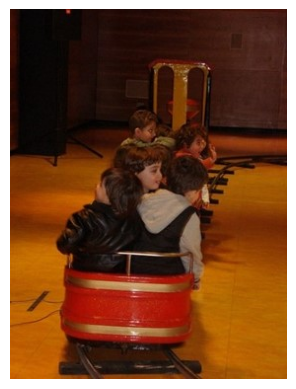


Caption thực tế: some children are riding on a mini orange train
Greedy Caption : a group of people sitting on a room
Beam Caption   : a group of people sitting on a living room

🔍 BLEU-2 Score:
   - Greedy     : 0.3536
   - Beam Search: 0.3333

BLEU Score (nltk - Greedy): 0.3836
BLEU Score (sacrebleu - Greedy): 9.747


In [52]:
from tensorflow.keras.models import load_model
import pickle
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.translate.bleu_score import corpus_bleu, sentence_bleu
import numpy as np
import matplotlib.pyplot as plt
import sacrebleu
#from sentence_transformers import SentenceTransformer, util

# Load mô hình và tokenizer
caption_model = load_model('/kaggle/working/my_model_02.keras')
with open('/kaggle/working/tokenizer.pickle', 'rb') as f:
    tokenizer = pickle.load(f)
cnn_output_dim = 2048

# Load CNN để trích đặc trưng
base_model = InceptionV3(weights='imagenet')
cnn_model = Model(base_model.input, base_model.layers[-2].output)

# Hàm trích đặc trưng ảnh
def extract_features(image_path):
    img = load_img(image_path, target_size=(299, 299))
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    features = cnn_model.predict(x, verbose=0)
    return features.reshape(-1)

# Hàm sinh caption Greedy
def greedy_generator(image_features, max_caption_length=27): 
    in_text = 'start'
    for _ in range(max_caption_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_caption_length).reshape((1, max_caption_length))
        prediction = caption_model.predict([image_features.reshape(1, cnn_output_dim), sequence], verbose=0)
        idx = np.argmax(prediction)
        word = tokenizer.index_word.get(idx, '')  # Dùng get tránh lỗi nếu idx không nằm trong tokenizer
        in_text += ' ' + word
        if word == 'end':
            break
    in_text = in_text.replace('start ', '').replace(' end', '')
    return in_text

# Hàm sinh caption Beam Search
def beam_search_generator(image_features, K_beams=3, max_caption_length=27):
    start = [tokenizer.word_index['start']]
    start_word = [[start, 0.0]]
    
    for _ in range(max_caption_length):
        temp = []
        for s in start_word:
            sequence = pad_sequences([s[0]], maxlen=max_caption_length).reshape((1, max_caption_length))
            preds = caption_model.predict([image_features.reshape(1, cnn_output_dim), sequence], verbose=0)
            word_preds = np.argsort(preds[0])[-K_beams:]
            
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += np.log(preds[0][w])
                temp.append([next_cap, prob])
                
        start_word = sorted(temp, key=lambda l: l[1])[-K_beams:]
    
    final_seq = start_word[-1][0]
    final_words = [tokenizer.index_word.get(i, '') for i in final_seq]
    final_caption = [w for w in final_words if w != 'end']
    
    return ' '.join(final_caption[1:])

# Hàm BLEU
def BLEU_score(actual, greedy, beam_search):
    score_greedy = corpus_bleu([actual], [greedy], weights=(0.5, 0.5))
    score_beam = corpus_bleu([actual], [beam_search], weights=(0.5, 0.5))
    return score_greedy, score_beam

# Hàm tính BLEU bằng nltk
def bleu_score_nltk(reference, hypothesis):
    score = sentence_bleu([reference], hypothesis)
    return score

# Hàm tính BLEU bằng sacrebleu
def bleu_score_sacrebleu(reference, hypothesis):
    bleu = sacrebleu.sentence_bleu(hypothesis, [reference])
    return bleu.score

# Hàm tính cosine similarity
def cosine_similarity(sentence1, sentence2):
    model = SentenceTransformer('sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2')
    embeddings = model.encode([sentence1, sentence2], convert_to_tensor=True)
    similarity = util.pytorch_cos_sim(embeddings[0], embeddings[1])
    return similarity.item()

# Đường dẫn ảnh và caption thực tế
image_path = '/kaggle/input/testck/Picture1.jpg'
actual_caption = 'some children are riding on a mini orange train'

# ==== Xử lý ====
features = extract_features(image_path)
greedy_cap = greedy_generator(features)
beam_cap = beam_search_generator(features)

# ==== In kết quả ====
print("\nẢnh:", image_path)
plt.imshow(load_img(image_path))
plt.axis('off')
plt.show()

print("\nCaption thực tế:", actual_caption)
print("Greedy Caption :", greedy_cap)
print("Beam Caption   :", beam_cap)

# Tính BLEU-2 score (corpus_bleu)
bleu_g, bleu_b = BLEU_score(actual_caption.split(), greedy_cap.split(), beam_cap.split())
print(f"\n🔍 BLEU-2 Score:")
print(f"   - Greedy     : {round(bleu_g, 4)}")
print(f"   - Beam Search: {round(bleu_b, 4)}")

# Tính BLEU score với NLTK
reference_nltk = actual_caption.split()
bleu_nltk = bleu_score_nltk(reference_nltk, greedy_cap.split())
print(f"\nBLEU Score (nltk - Greedy): {round(bleu_nltk, 4)}")

# Tính BLEU score với SacreBLEU
bleu_sacrebleu = bleu_score_sacrebleu(actual_caption, greedy_cap)
print(f"BLEU Score (sacrebleu - Greedy): {round(bleu_sacrebleu, 4)}")

# Tính Cosine Similarity
#cosine_sim = cosine_similarity(actual_caption, greedy_cap)
#print(f"Cosine Similarity (Greedy): {round(cosine_sim, 4)}")


# InceptionV3 và LSTM (Flickr30k dataset)

## Import data

In [5]:
images_directory = '/kaggle/input/flickr-image-dataset/flickr30k_images/flickr30k_images/'
captions_path = '/kaggle/input/flickr-image-dataset/flickr30k_images/results.csv'


In [3]:
def load_captions(file_path):
    import pandas as pd

    # Đọc file CSV Flickr30k
    df = pd.read_csv(file_path, sep='|', skipinitialspace=True)
    df.columns = df.columns.str.strip()
    df = df.dropna(subset=['comment'])  # Bỏ caption rỗng

    # Làm sạch khoảng trắng
    df['image_name'] = df['image_name'].str.strip()
    df['comment'] = df['comment'].astype(str).str.strip().str.lower()

    # Tạo danh sách theo format: "image_name,caption"
    captions = [f"{row['image_name']},{row['comment']}" for _, row in df.iterrows()]
    return captions


In [6]:
captions = load_captions(captions_path)
captions[:15:3]

['1000092795.jpg,two young guys with shaggy hair look at their hands while hanging out in the yard .',
 '1000092795.jpg,a man in a blue shirt standing in a garden .',
 '10002456.jpg,workers look down from up above on a piece of equipment .',
 '10002456.jpg,three men on a large rig .',
 '1000268201.jpg,a little girl climbing the stairs to her playhouse .']

In [7]:
def tokenize_captions(captions_list):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(captions_list)
    return tokenizer


## Cleaning captions

In [8]:
def clean_text(text):
    # Removing punctuation marks
    text = re.sub(r'[^\w\s]', '', text)
    
    # Removing numbers
    text = re.sub(r'\d+', '', text)
    
    # Removing extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

# Cleaning the captions
cleaned_captions = [clean_text(caption.split(',')[1]) for caption in captions]
cleaned_captions[:15:2]

['two young guys with shaggy hair look at their hands while hanging out in the yard',
 'two men in green shirts are standing in a yard',
 'two friends enjoy time spent together',
 'workers look down from up above on a piece of equipment',
 'four men on top of a tall structure',
 'a child in a pink dress is climbing up a set of stairs in an entry way',
 'a little girl climbing the stairs to her playhouse',
 'a girl going into a wooden building']

In [9]:
# Image ID + \t + Caption
captions_IDs = []
for i in range(len(cleaned_captions)):
    #  Adding 'start' word and 'end' word to the captions
    item = captions[i].split(',')[0]+'\t'+'start '+cleaned_captions[i]+' end\n'
    captions_IDs.append(item)
    
captions_IDs[:20:3], len(captions_IDs)

(['1000092795.jpg\tstart two young guys with shaggy hair look at their hands while hanging out in the yard end\n',
  '1000092795.jpg\tstart a man in a blue shirt standing in a garden end\n',
  '10002456.jpg\tstart workers look down from up above on a piece of equipment end\n',
  '10002456.jpg\tstart three men on a large rig end\n',
  '1000268201.jpg\tstart a little girl climbing the stairs to her playhouse end\n',
  '1000344755.jpg\tstart someone in a blue shirt and hat is standing on stair and leaning against a window end\n',
  '1000344755.jpg\tstart man in blue shirt and jeans on ladder cleaning windows end\n'],
 158914)

## In vài ảnh và Tokenizing

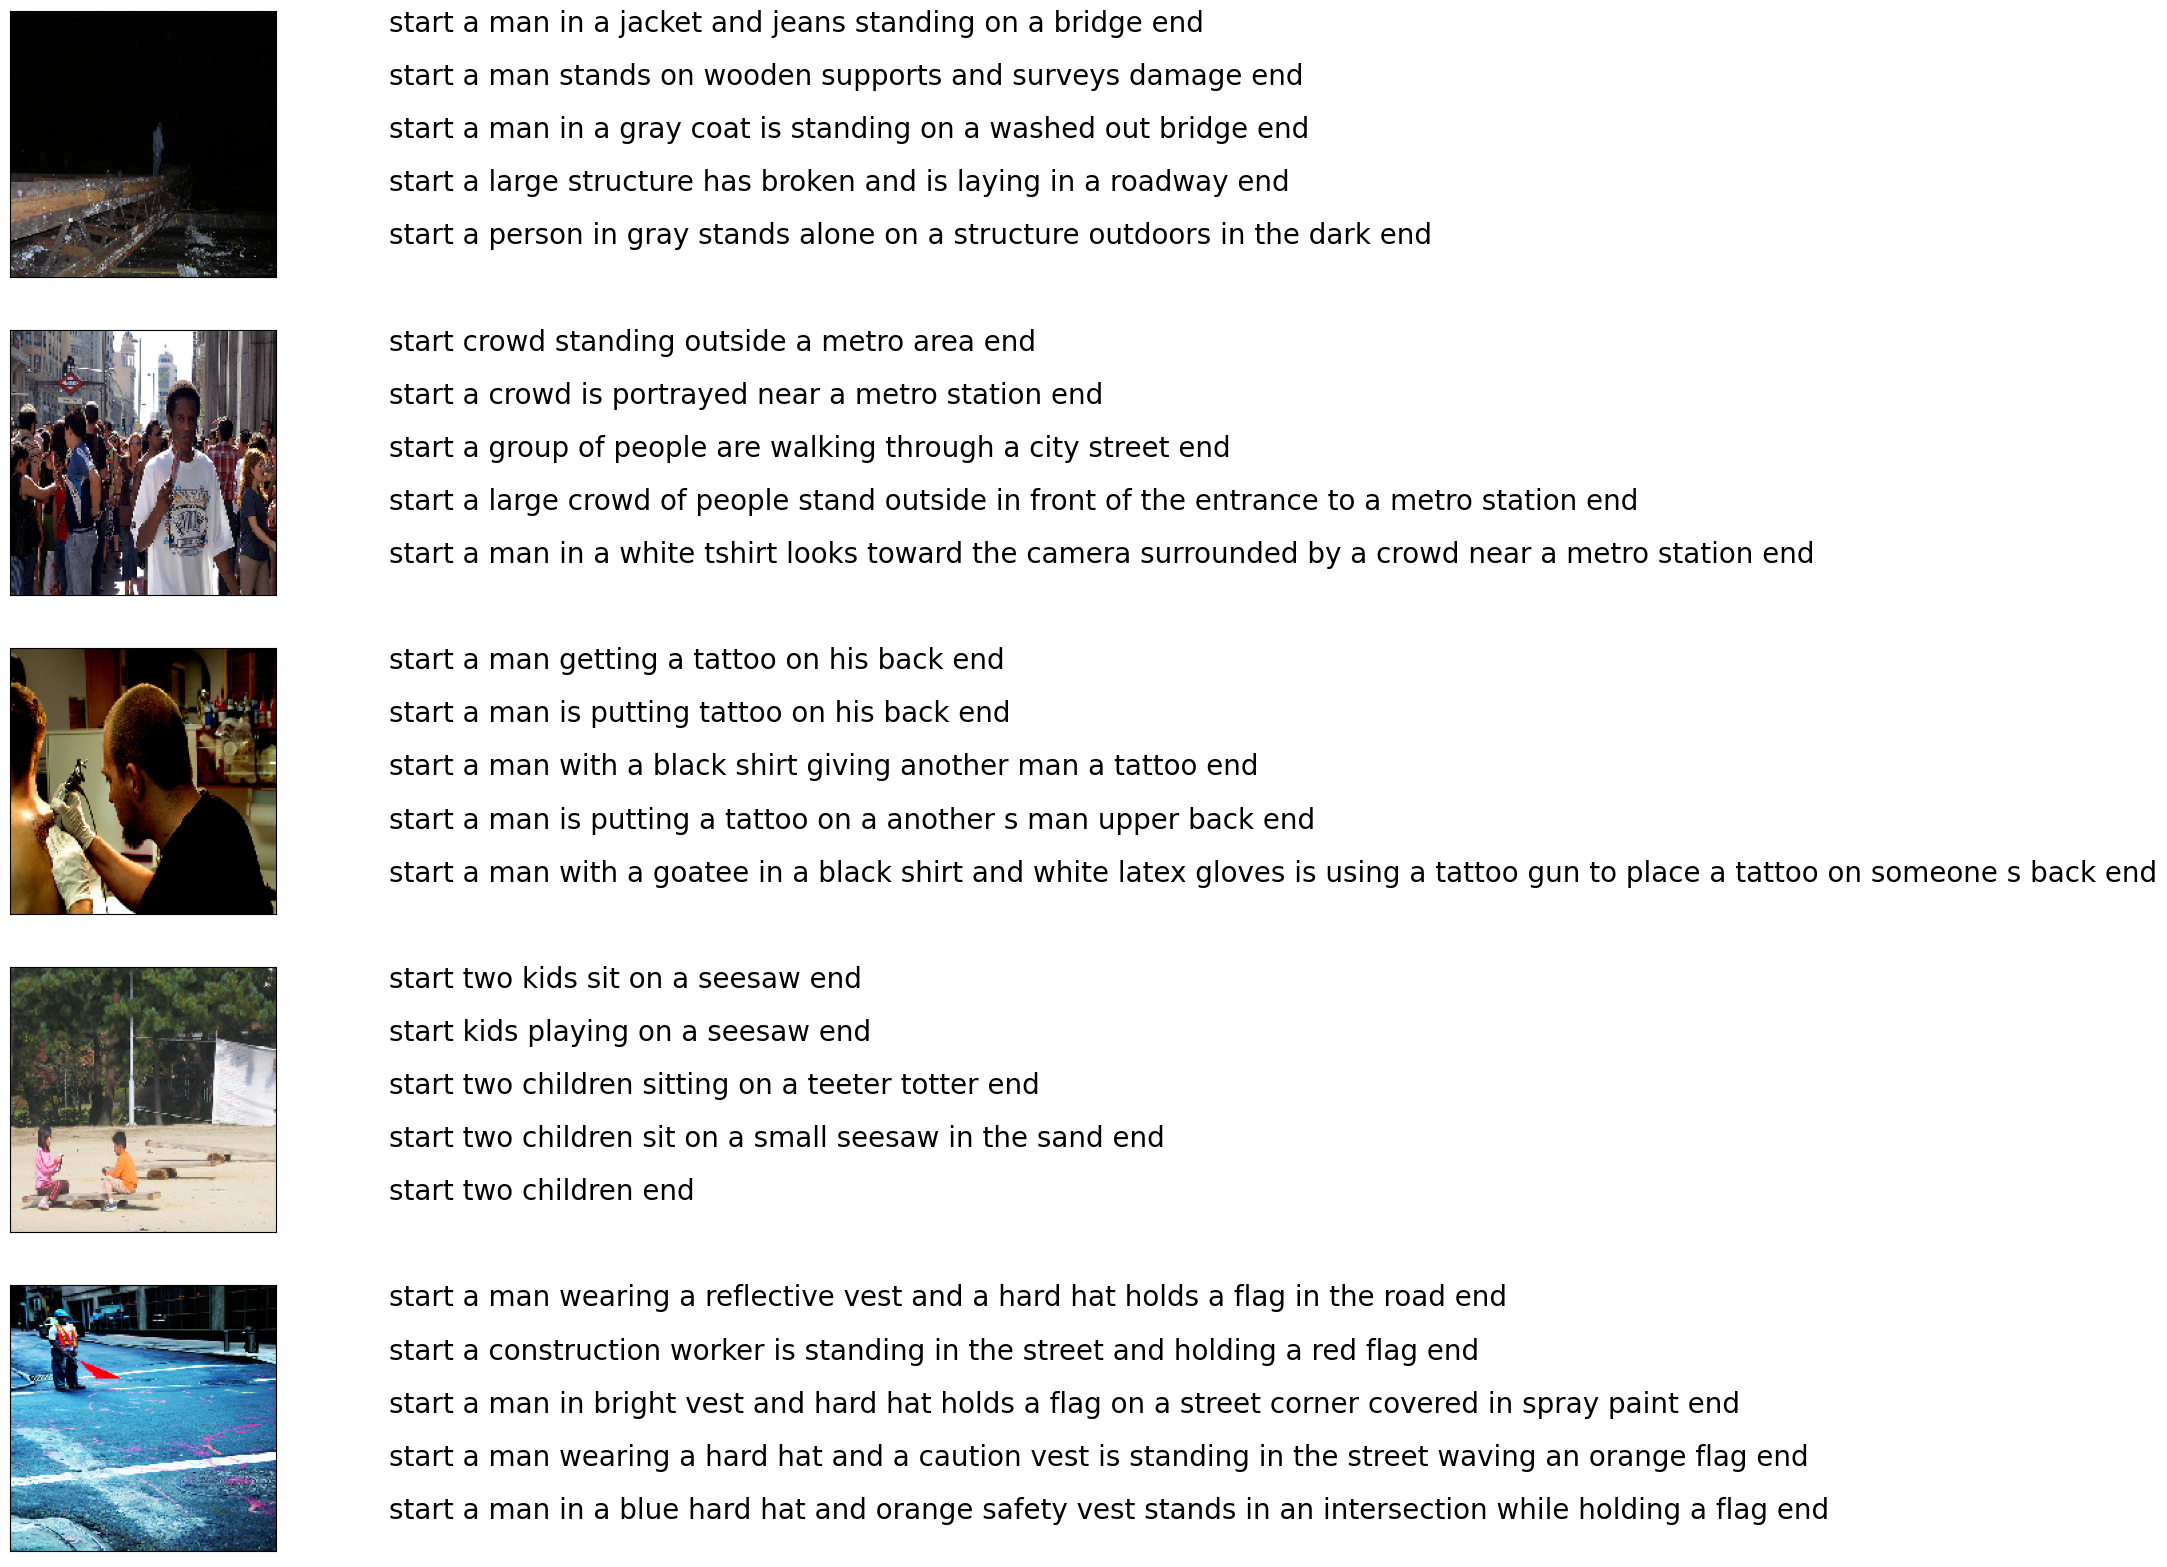

In [10]:
def visualaization(data, num_of_images):
    # We use dictionaries to access captions of each image by its ID
    captions_dictionary = {}
    for item in data[100:100+(num_of_images)*5]:
        image_id, caption = item.split('\t')
        if image_id not in captions_dictionary:
            captions_dictionary[image_id] = []
        captions_dictionary[image_id].append(caption)
    else:
        list_captions = [x for x in captions_dictionary.items()]
    
    count = 1
    fig = plt.figure(figsize=(10,20))
    for filename in list(captions_dictionary.keys()):
        captions = captions_dictionary[filename]
        image_load = load_img(images_directory+filename, target_size=(199,199,3))

        ax = fig.add_subplot(num_of_images,2,count,xticks=[],yticks=[])
        ax.imshow(image_load)
        count += 1

        ax = fig.add_subplot(num_of_images,2,count)
        plt.axis('off')
        ax.plot()
        ax.set_xlim(0,1)
        ax.set_ylim(0,len(captions))
        for i, caption in enumerate(captions):
            ax.text(0,i,caption,fontsize=20)
        count += 1
    plt.show()
    
visualaization(captions_IDs, 5)

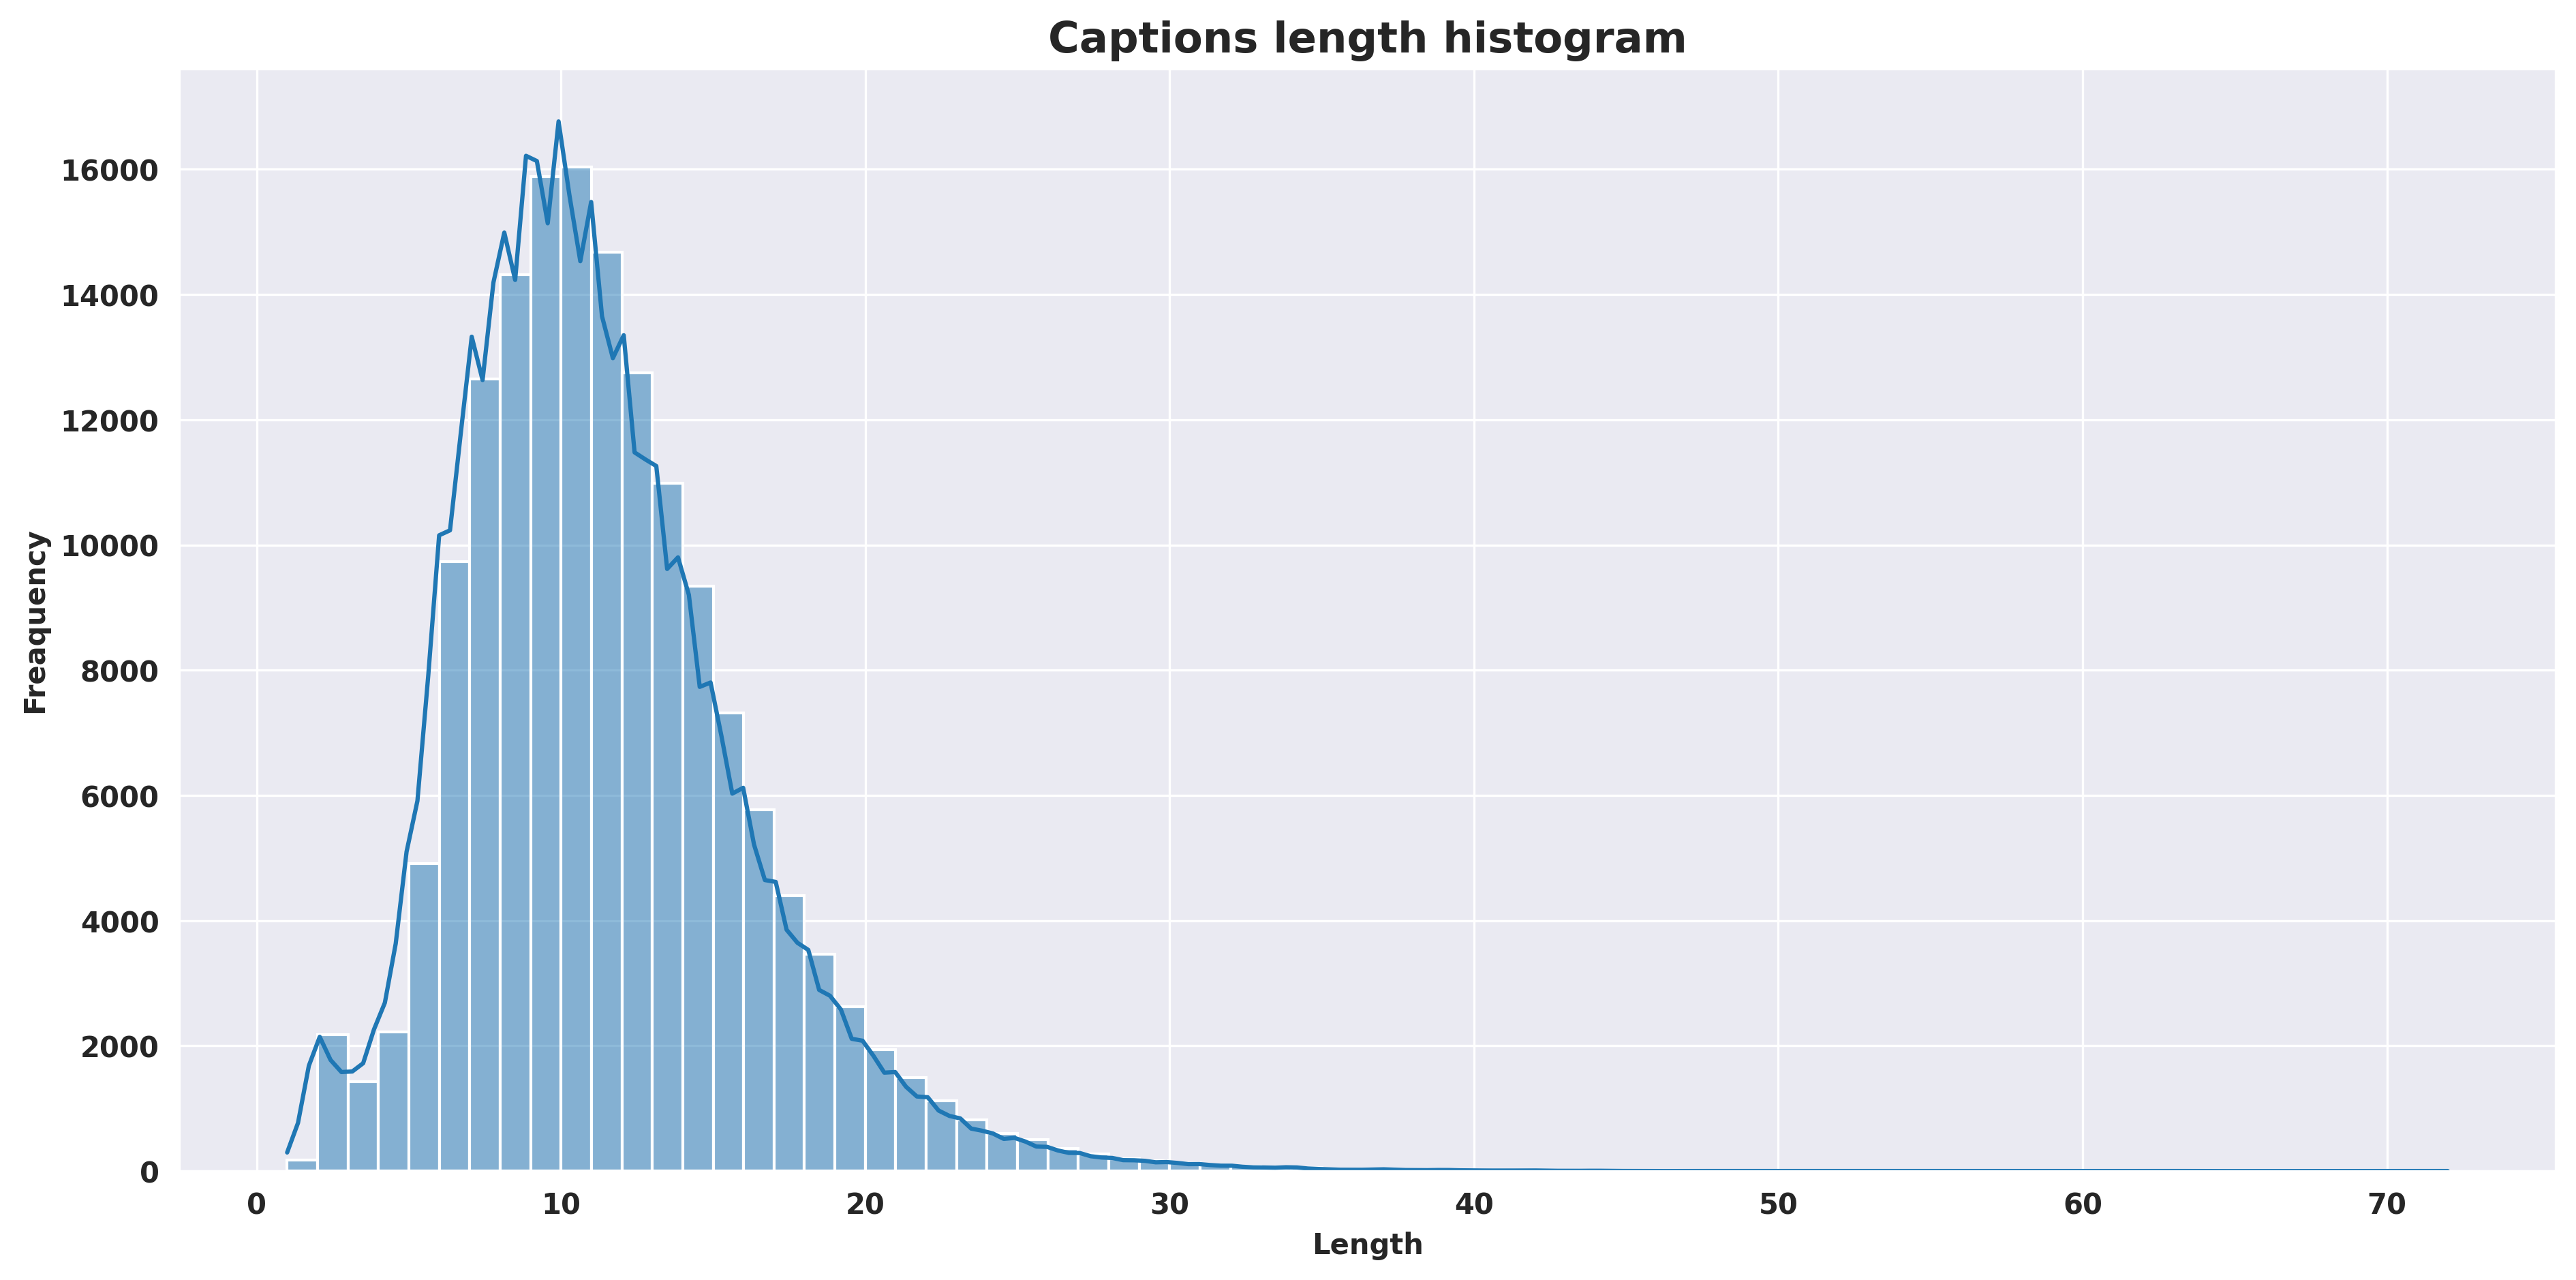

In [11]:
def captions_length(data):
    plt.figure(figsize=(15, 7), dpi=300)
    sns.set_style('darkgrid')
    sns.histplot(x=[len(x.split(' ')) for x in data], kde=True, binwidth=1) 
    plt.title('Captions length histogram', fontsize=15, fontweight='bold')
    plt.xticks(fontweight='bold')
    plt.yticks(fontweight='bold')
    plt.xlabel('Length', fontweight='bold')
    plt.ylabel('Freaquency', fontweight='bold')
    plt.show()
    
captions_length(cleaned_captions)

### Tokenizing captions

In [12]:
# Tokenizing the captions and creating word-to-index mapping
tokenizer = tokenize_captions(cleaned_captions)
vocab_size = len(tokenizer.word_index) + 1
vocab_size

18725

In [13]:
import pickle

# Lưu tokenizer vào file
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Split data

In [14]:
# Storing all image IDs
all_image_ids = os.listdir(images_directory)

# Splitting image IDs
train_image_ids, val_image_ids = train_test_split(all_image_ids, test_size=0.15, random_state=42)
val_image_ids, test_image_ids = train_test_split(val_image_ids, test_size=0.1, random_state=42)

train_captions, val_captions, test_captions = [], [], []
for caption in captions_IDs:
    image_id, _ = caption.split('\t')
    
    if image_id in train_image_ids:
        train_captions.append(caption)
        
    elif image_id in val_image_ids:
        val_captions.append(caption)        

    elif image_id in test_image_ids:
        test_captions.append(caption)
        
    else:
        print('Unknown image ID !')

train_captions[0], val_captions[0], test_captions[0], len(train_captions)/5, len(val_captions)/5, len(test_captions)/5

('1000092795.jpg\tstart two young guys with shaggy hair look at their hands while hanging out in the yard end\n',
 '1000523639.jpg\tstart two people in the photo are playing the guitar and the other is poking at him end\n',
 '1015712668.jpg\tstart a man in a red longsleeved shirt bikes over a body of water on a bridge end\n',
 27014.8,
 4291.0,
 477.0)

## Trích xuất đặc trưng (InceptionV3)

In [15]:
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(299, 299))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img

def extract_image_features(model, image_path):
    img = preprocess_image(image_path)
    features = model.predict(img, verbose=0)
    return features

# Loading the pre-trained InceptionV3 model
inception_v3_model = InceptionV3(weights = 'imagenet', input_shape=(299, 299, 3))
inception_v3_model.layers.pop()
inception_v3_model = Model(inputs=inception_v3_model.inputs, outputs=inception_v3_model.layers[-2].output)

I0000 00:00:1746755374.250628      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


96112376/96112376 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [16]:
train_image_features, val_image_features, test_image_features = {}, {}, {}

pbar = tqdm(total=len(all_image_ids), position=0, leave=True, colour='green')

for caption in all_image_ids:
    image_id = caption.split('\t')[0]
    image_path = os.path.join(images_directory, image_id)
    
    # Kiểm tra nếu tệp ảnh tồn tại
    if not os.path.isfile(image_path):
        print(f"Không tìm thấy tệp ảnh: {image_path}")
        continue
    
    try:
        image_features = extract_image_features(inception_v3_model, image_path)  # Extracting features
    except Exception as e:
        print(f"Không thể xử lý ảnh {image_id} tại {image_path} với lỗi: {str(e)}")
        continue  # Tiếp tục với ảnh tiếp theo nếu có lỗi

    if image_id in train_image_ids:
        train_image_features[image_id] = image_features.flatten()  # Flattening the features
        pbar.update(1)
    
    elif image_id in val_image_ids:
        val_image_features[image_id] = image_features.flatten()  # Flattening the features
        pbar.update(1)
    
    elif image_id in test_image_ids:
        test_image_features[image_id] = image_features.flatten()  # Flattening the features
        pbar.update(1)
    
    else:
        print(f'Ảnh {image_id} không có trong danh sách train/val/test')

pbar.close()


  0%|          | 0/31785 [00:00<?, ?it/s]WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
I0000 00:00:1746755383.685653     100 service.cc:148] XLA service 0x794578003ac0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746755383.686442     100 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1746755384.645876     100 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1746755388.793002     100 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
 31%|███       | 9747/31785 [14:08<34:37, 10.61it/s]  

Không tìm thấy tệp ảnh: /kaggle/input/flickr-image-dataset/flickr30k_images/flickr30k_images/flickr30k_images


 83%|████████▎ | 26248/31785 [38:21<11:22,  8.12it/s]

Không thể xử lý ảnh results.csv tại /kaggle/input/flickr-image-dataset/flickr30k_images/flickr30k_images/results.csv với lỗi: cannot identify image file <_io.BytesIO object at 0x79464f0d7e70>


100%|█████████▉| 31783/31785 [46:28<00:00, 11.40it/s]


## Model

In [36]:
def data_generator(captions, image_features, tokenizer, max_caption_length, batch_size):
    num_samples = len(captions)
    image_ids = list(image_features.keys())
    while True:
        np.random.shuffle(image_ids)  # Shuffle image_ids for each epoch
        for start_idx in range(0, num_samples, batch_size):
            end_idx = min(start_idx + batch_size, num_samples)
            X_images, X_captions, y = [], [], []
            for caption in captions[start_idx:end_idx]:
                image_id, caption_text = caption.split('\t')
                caption_text = caption_text.rstrip('\n')
                seq = tokenizer.texts_to_sequences([caption_text])[0] # Tokenizing the caption
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i] # X_caption, Y
                    in_seq = pad_sequences([in_seq], maxlen=max_caption_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    X_images.append(image_features[image_id])
                    X_captions.append(in_seq)
                    y.append(out_seq)
            
            yield (np.array(X_images), np.array(X_captions)), np.array(y)
         
        
# Defining the maximum length of captions
max_caption_length = max(len(caption.split()) for caption in cleaned_captions) + 1

# Defining the CNN output dimension (size of feature vector from InceptionV3)
cnn_output_dim = inception_v3_model.output_shape[1] # 2048

# Defining batch size
batch_size_train = 270
batch_size_val = 150

# Creating data generators for training and validation
train_data_generator = data_generator(train_captions, train_image_features, tokenizer, max_caption_length, batch_size_train)
val_data_generator = data_generator(val_captions, val_image_features, tokenizer, max_caption_length, batch_size_val)

In [29]:
# Checking shapes
sample_batch = next(train_data_generator)
print("Training sample batch shapes:")
print("X_images:", sample_batch[0][0].shape)
print("X_captions:", sample_batch[0][1].shape)
print("y:", sample_batch[1].shape)
print('=========================')
sample_batch = next(val_data_generator)
print("Validation sample batch shapes:")
print("X_images:", sample_batch[0][0].shape)
print("X_captions:", sample_batch[0][1].shape)
print("y:", sample_batch[1].shape)

Training sample batch shapes:
X_images: (3383, 2048)
X_captions: (3383, 73)
y: (3383, 18725)
Validation sample batch shapes:
X_images: (1867, 2048)
X_captions: (1867, 73)
y: (1867, 18725)


In [32]:
def build_model(vocab_size, max_caption_length, cnn_output_dim):
    # Encoder Model
    input_image = Input(shape=(cnn_output_dim,), name='Features_Input')
    fe1 = BatchNormalization()(input_image)
    fe2 = Dense(256, activation='relu')(fe1) # Adding a Dense layer to the CNN output to match the decoder output size
    fe3 = BatchNormalization()(fe2)
    
    # Decoder Model
    input_caption = Input(shape=(max_caption_length,), name='Sequence_Input')
    se1 = Embedding(vocab_size, 256, mask_zero=True)(input_caption)
    se2 = LSTM(256)(se1)
    
    # Output
    decoder1 = add([fe3, se2])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax', name='Output_Layer')(decoder2)

    # Returning The Model
    model = Model(inputs=[input_image, input_caption], outputs=outputs, name='Image_Captioning')
    return model
    
# Building the model
caption_model = build_model(vocab_size, max_caption_length, cnn_output_dim)

optimizer = Adam(learning_rate=1e-3, clipnorm=1.0)
caption_model.compile(loss='categorical_crossentropy', optimizer=optimizer)

caption_model.summary()

Model: "Image_Captioning"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Features_Input            │ (None, 2048)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_98    │ (None, 2048)           │          8,192 │ Features_Input[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Sequence_Input            │ (None, 73)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 256)            │        524,544 │ batch_normalization_9… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_2 (Embedding)   │ (None, 73, 256)        │      4,793,600 │ Sequence_Input[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal_2 (NotEqual)    │ (None, 73)             │              0 │ Sequence_Input[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_99    │ (None, 256)            │          1,024 │ dense_4[0][0]          │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_2 (LSTM)             │ (None, 256)            │        525,312 │ embedding_2[0][0],     │
│                           │                        │                │ not_equal_2[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_2 (Add)               │ (None, 256)            │              0 │ batch_normalization_9… │
│                           │                        │                │ lstm_2[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 256)            │         65,792 │ add_2[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Output_Layer (Dense)      │ (None, 18725)          │      4,812,325 │ dense_5[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 10,730,789 (40.93 MB)

 Trainable params: 10,726,181 (40.92 MB)

 Non-trainable params: 4,608 (18.00 KB)

In [ ]:
# Defining early stopping callback to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

def lr_scheduler(epoch, lr):
    return float(lr * tf.math.exp(-0.6))

# Learning Rate Scheduler
lr_schedule = LearningRateScheduler(lr_scheduler)

history = caption_model.fit(train_data_generator, steps_per_epoch=len(train_captions) // batch_size_train,
                        validation_data=val_data_generator, validation_steps=len(val_captions) // batch_size_val,
                        epochs=15, callbacks=[early_stopping, lr_schedule])

In [ ]:
# Lưu mô hình đã huấn luyện
caption_model.save('/kaggle/working/my_model_04.keras')


In [ ]:
plt.figure(figsize=(15, 7), dpi=200)
sns.set_style('whitegrid')
plt.plot([x+1 for x in range(len(history.history['loss']))], history.history['loss'], color='#E74C3C', marker='o')
plt.plot([x+1 for x in range(len(history.history['loss']))], history.history['val_loss'], color='#641E16', marker='h')
plt.title('Train VS Validation', fontsize=15, fontweight='bold')
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')
plt.xlabel('Epoch', fontweight='bold')
plt.ylabel('Loss', fontweight='bold')
plt.legend(['Train Loss', 'Validation Loss'], loc='best')
plt.show()

In [58]:
def greedy_generator(image_features): # A function to generate captions
    # Each caption is started with the word 'start'
    in_text = 'start '
    for _ in range(max_caption_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_caption_length).reshape((1,max_caption_length))
        prediction = caption_model.predict([image_features.reshape(1,cnn_output_dim), sequence], verbose=0)
        idx = np.argmax(prediction)
        word = tokenizer.index_word[idx]
        # Adding the predicted word to the sequence
        in_text += ' ' + word
        # When the model returns the word 'end' (which is the end word), the generating loop must be stopped 
        if word == 'end':
            break
            
    in_text = in_text.replace('start ', '')
    in_text = in_text.replace(' end', '')
    
    return in_text
def beam_search_generator(image_features, K_beams = 3, log = False):
    start = [tokenizer.word_index['start']]
    
    start_word = [[start, 0.0]]
    
    for _ in range(max_caption_length):
        temp = []
        for s in start_word:
            # Sequence of most probable words based on the previous steps
            sequence  = pad_sequences([s[0]], maxlen=max_caption_length).reshape((1,max_caption_length))
            
            preds = caption_model.predict([image_features.reshape(1,cnn_output_dim), sequence], verbose=0)
            
            # Sorting predictions by the probability and taking the last K_beams items.
            word_preds = np.argsort(preds[0])[-K_beams:]
            
            # Getting the top <K_beams>(n) predictions and creating a 
            #                              new list so as to put them via the model again.
            for w in word_preds:
                
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                if log:
                    prob += np.log(preds[0][w]) # assign a probability to each K words
                else:
                    prob += preds[0][w]
                temp.append([next_cap, prob])
                
        start_word = temp
        # Sorting according to the probabilities
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])

        # Getting the top words
        start_word = start_word[-K_beams:]
    
    start_word = start_word[-1][0]
    captions_ = [tokenizer.index_word[i] for i in start_word]

    final_caption = []
    
    for i in captions_:
        if i != 'end':
            final_caption.append(i)
        else:
            break
    
    final_caption = ' '.join(final_caption[1:])
    return final_caption

In [ ]:
# Calculates BLEU score of predictions
def BLEU_score(actual, greedy, beam_search):
    # Calculating the BLEU score by comparing the predicted caption with five actual captions.
    score_greedy_1 = corpus_bleu(actual, greedy, weights=(0.3, 0.3, 0.3, 0))
    score_greedy_2 = corpus_bleu(actual, greedy, weights=(0.25, 0.25, 0.25, 0.25))
    score_BS_1 = corpus_bleu(actual, beam_search, weights=(0.3, 0.3, 0.3, 0))
    score_BS_2 = corpus_bleu(actual, beam_search, weights=(0.25, 0.25, 0.25, 0.25))
    
    return [
        (f'BLEU-2 Greedy: {round(score_BS_2, 5)}'),
        (f'BLEU-1 Greedy: {round(score_BS_1, 5)}'),
        (f'Greedy: {greedy[0]}'),
        (f'BLEU-2 Beam Search: {round(score_greedy_2, 5)}'),
        (f'BLEU-1 Beam Search: {round(score_greedy_1, 5)}'),
        (f'Beam Search:  {beam_search[0]}')
    ]

In [ ]:
# A dictionary to access actual captions of each image by its ID
test_actual_captions = {}
for item in test_captions:
    image_id, caption = item.split('\t')
    if image_id not in test_actual_captions:
        test_actual_captions[image_id] = []
    test_actual_captions[image_id].append(caption)

In [ ]:
# Generating captions
generated_captions = {}

pbar = tqdm_notebook(total=len(test_image_features), position=0, leave=True, colour='green')
for image_id in test_image_features:
    cap = greedy_generator(test_image_features[image_id])
    generated_captions[image_id] = cap
    pbar.update(1)
    
pbar.close()

In [ ]:
def visualization(data, greedy_caps, beamS_generator, evaluator, num_of_images):
    keys = list(data.keys()) # List of all test images
    images = [np.random.choice(keys) for i in range(num_of_images)] # Randomly selected images
    
    count = 1
    fig = plt.figure(figsize=(6,20))    
    for filename in images:
        actual_cap = data[filename]
        actual_cap = [x.replace("start ", "") for x in actual_cap] # Removing the start token
        actual_cap = [x.replace(" end", "") for x in actual_cap] # Removing the end token
        
        # Generating captions
        greedy_cap = greedy_caps[filename]
        beamS_cap = beamS_generator(test_image_features[filename])
        
        # Getting the bleu score
        caps_with_score = evaluator(actual_cap, [greedy_cap]*(len(actual_cap)), [beamS_cap]*(len(actual_cap)))
    
        image_load = load_img(images_directory+filename, target_size=(199,199,3))
        ax = fig.add_subplot(num_of_images,2,count,xticks=[],yticks=[])
        ax.imshow(image_load)
        count += 1

        ax = fig.add_subplot(num_of_images,2,count)
        plt.axis('off')
        ax.plot()
        ax.set_xlim(0,1)
        ax.set_ylim(0,len(caps_with_score))
        for i, text in enumerate(caps_with_score):
            ax.text(0,i,text,fontsize=10)
        count += 1
    plt.show()

visualization(test_actual_captions, generated_captions, beam_search_generator, BLEU_score, 7)

## Test 2

In [ ]:
!pip install sacrebleu --quiet

In [ ]:
from tensorflow.keras.models import load_model
import pickle
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.translate.bleu_score import corpus_bleu, sentence_bleu
import numpy as np
import matplotlib.pyplot as plt
import sacrebleu
#from sentence_transformers import SentenceTransformer, util

# Load mô hình và tokenizer
caption_model = load_model('/kaggle/working/my_model_04.keras')
with open('/kaggle/working/tokenizer.pickle', 'rb') as f:
    tokenizer = pickle.load(f)
cnn_output_dim = 2048

# Load CNN để trích đặc trưng
base_model = InceptionV3(weights='imagenet')
cnn_model = Model(base_model.input, base_model.layers[-2].output)

# Hàm trích đặc trưng ảnh
def extract_features(image_path):
    img = load_img(image_path, target_size=(299, 299))
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    features = cnn_model.predict(x, verbose=0)
    return features.reshape(-1)

# Hàm sinh caption Greedy
def greedy_generator(image_features, max_caption_length=73): 
    in_text = 'start'
    for _ in range(max_caption_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_caption_length).reshape((1, max_caption_length))
        prediction = caption_model.predict([image_features.reshape(1, cnn_output_dim), sequence], verbose=0)
        idx = np.argmax(prediction)
        word = tokenizer.index_word.get(idx, '')  # Dùng get tránh lỗi nếu idx không nằm trong tokenizer
        in_text += ' ' + word
        if word == 'end':
            break
    in_text = in_text.replace('start ', '').replace(' end', '')
    return in_text

# Hàm sinh caption Beam Search
def beam_search_generator(image_features, K_beams=3, max_caption_length=27):
    start = [tokenizer.word_index['start']]
    start_word = [[start, 0.0]]
    
    for _ in range(max_caption_length):
        temp = []
        for s in start_word:
            sequence = pad_sequences([s[0]], maxlen=max_caption_length).reshape((1, max_caption_length))
            preds = caption_model.predict([image_features.reshape(1, cnn_output_dim), sequence], verbose=0)
            word_preds = np.argsort(preds[0])[-K_beams:]
            
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += np.log(preds[0][w])
                temp.append([next_cap, prob])
                
        start_word = sorted(temp, key=lambda l: l[1])[-K_beams:]
    
    final_seq = start_word[-1][0]
    final_words = [tokenizer.index_word.get(i, '') for i in final_seq]
    final_caption = [w for w in final_words if w != 'end']
    
    return ' '.join(final_caption[1:])

# Hàm BLEU
def BLEU_score(actual, greedy, beam_search):
    score_greedy = corpus_bleu([actual], [greedy], weights=(0.5, 0.5))
    score_beam = corpus_bleu([actual], [beam_search], weights=(0.5, 0.5))
    return score_greedy, score_beam

# Hàm tính BLEU bằng nltk
def bleu_score_nltk(reference, hypothesis):
    score = sentence_bleu([reference], hypothesis)
    return score

# Hàm tính BLEU bằng sacrebleu
def bleu_score_sacrebleu(reference, hypothesis):
    bleu = sacrebleu.sentence_bleu(hypothesis, [reference])
    return bleu.score

# Hàm tính cosine similarity
def cosine_similarity(sentence1, sentence2):
    model = SentenceTransformer('sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2')
    embeddings = model.encode([sentence1, sentence2], convert_to_tensor=True)
    similarity = util.pytorch_cos_sim(embeddings[0], embeddings[1])
    return similarity.item()

# Đường dẫn ảnh và caption thực tế
image_path = '/kaggle/input/testck/Picture1.jpg'
actual_caption = 'some children are riding on a mini orange train'

# ==== Xử lý ====
features = extract_features(image_path)
greedy_cap = greedy_generator(features)
beam_cap = beam_search_generator(features)

# ==== In kết quả ====
print("\nẢnh:", image_path)
plt.imshow(load_img(image_path))
plt.axis('off')
plt.show()

print("\nCaption thực tế:", actual_caption)
print("Greedy Caption :", greedy_cap)
print("Beam Caption   :", beam_cap)

# Tính BLEU-2 score (corpus_bleu)
bleu_g, bleu_b = BLEU_score(actual_caption.split(), greedy_cap.split(), beam_cap.split())
print(f"\n🔍 BLEU-2 Score:")
print(f"   - Greedy     : {round(bleu_g, 4)}")
print(f"   - Beam Search: {round(bleu_b, 4)}")

# Tính BLEU score với NLTK
reference_nltk = actual_caption.split()
bleu_nltk = bleu_score_nltk(reference_nltk, greedy_cap.split())
print(f"\nBLEU Score (nltk - Greedy): {round(bleu_nltk, 4)}")

# Tính BLEU score với SacreBLEU
bleu_sacrebleu = bleu_score_sacrebleu(actual_caption, greedy_cap)
print(f"BLEU Score (sacrebleu - Greedy): {round(bleu_sacrebleu, 4)}")

# Tính Cosine Similarity
#cosine_sim = cosine_similarity(actual_caption, greedy_cap)
#print(f"Cosine Similarity (Greedy): {round(cosine_sim, 4)}")


# Fine-tune Blip với dataset Flickr

In [1]:
import pandas as pd


# Đọc file CSV với dấu phân cách là '|', loại bỏ khoảng trắng thừa
file_path = '/kaggle/input/flickr-image-dataset/flickr30k_images/results.csv'

# Đọc file CSV và loại bỏ khoảng trắng thừa
df = pd.read_csv(file_path, sep='|', skipinitialspace=True)

# Loại bỏ khoảng trắng thừa ở các cột
df.columns = df.columns.str.strip()

# Hiển thị một số dòng đầu
print(df.head())


       image_name comment_number  \
0  1000092795.jpg              0   
1  1000092795.jpg              1   
2  1000092795.jpg              2   
3  1000092795.jpg              3   
4  1000092795.jpg              4   

                                             comment  
0  Two young guys with shaggy hair look at their ...  
1  Two young , White males are outside near many ...  
2   Two men in green shirts are standing in a yard .  
3       A man in a blue shirt standing in a garden .  
4            Two friends enjoy time spent together .  


In [1]:
import json
import os
import torch
from PIL import Image
from torch.utils.data import Dataset
from transformers import AutoProcessor, BlipForConditionalGeneration
import pandas as pd
from torch.utils.data import DataLoader

class Flickr30kDataset(Dataset):
    def __init__(self, annotations_path, images_dir, processor, transform=None, max_samples=None):
        # Đọc file CSV chứa captions
        self.df = pd.read_csv(annotations_path, sep='|', skipinitialspace=True)
        self.df.columns = self.df.columns.str.strip()  # Loại bỏ khoảng trắng thừa
        self.images_dir = images_dir
        self.processor = processor
        self.transform = transform

        # Lấy danh sách id ảnh
        self.ids = self.df['image_name'].unique()  # Sử dụng image_name làm id ảnh
        if max_samples:
            self.ids = self.ids[:max_samples]

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        image_name = self.ids[idx]
        # Lọc các captions của ảnh này
        captions = self.df[self.df['image_name'] == image_name]['comment'].tolist()
        caption = captions[0]  # Lấy caption đầu tiên (hoặc bạn có thể xử lý để lấy nhiều hơn)

        # Đường dẫn ảnh
        image_path = os.path.join(self.images_dir, image_name)
        image = Image.open(image_path).convert("RGB")

        # Xử lý input cho BLIP
        encoding = self.processor(images=image, text=caption, padding="max_length", return_tensors="pt")
        encoding = {k: v.squeeze() for k, v in encoding.items()}
        return encoding


2025-05-08 02:47:24.462680: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746672444.652069      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746672444.704357      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Cấu hình model và processor
processor = AutoProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

BlipForConditionalGeneration(
  (vision_model): BlipVisionModel(
    (embeddings): BlipVisionEmbeddings(
      (patch_embedding): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (encoder): BlipEncoder(
      (layers): ModuleList(
        (0-11): 12 x BlipEncoderLayer(
          (self_attn): BlipAttention(
            (dropout): Dropout(p=0.0, inplace=False)
            (qkv): Linear(in_features=768, out_features=2304, bias=True)
            (projection): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): BlipMLP(
            (activation_fn): GELUActivation()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
          )
          (layer_norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
      )
    )
    (post_layernorm): LayerNorm((768,), eps=1e-0

In [4]:
# Cập nhật đường dẫn tới dữ liệu của bạn
train_annotations = "/kaggle/input/flickr-image-dataset/flickr30k_images/results.csv"
train_images_dir = "/kaggle/input/flickr-image-dataset/flickr30k_images/flickr30k_images"

train_dataset = Flickr30kDataset(train_annotations, train_images_dir, processor, max_samples=20000)  # dùng 20k ảnh cho nhanh
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=2)

In [5]:
# Huấn luyện model
from tqdm import tqdm  # thêm thư viện thanh tiến trình

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
model.train()

for epoch in range(2):  
    print(f"Epoch {epoch + 1}")
    
    # tqdm hiển thị tiến trình huấn luyện cho từng batch
    progress_bar = tqdm(train_dataloader, desc=f"Training Epoch {epoch + 1}")

    for batch in progress_bar:
        input_ids = batch.pop("input_ids").to(device)
        pixel_values = batch.pop("pixel_values").to(device)

        outputs = model(input_ids=input_ids,
                        pixel_values=pixel_values,
                        labels=input_ids)
        
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # cập nhật hiển thị loss lên thanh tiến trình
        progress_bar.set_postfix(loss=loss.item())


Epoch 1


Training Epoch 1: 100%|██████████| 10000/10000 [1:10:42<00:00,  2.36it/s, loss=0.158]


Epoch 2


Training Epoch 2: 100%|██████████| 10000/10000 [1:08:31<00:00,  2.43it/s, loss=0.152]


In [7]:
model.save_pretrained("blip_model")
processor.save_pretrained("blip_model/processor")  # lưu trong thư mục con


[]

In [8]:
import shutil

shutil.make_archive("blip_model", 'zip', "blip_model")


'/kaggle/working/blip_model.zip'

## Test 3

In [1]:
!pip install sacrebleu --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 4.2 MB/s eta 0:00:00


In [25]:
import torch
from PIL import Image
from transformers import AutoProcessor, BlipForConditionalGeneration
import nltk
from nltk.translate.bleu_score import sentence_bleu
import sacrebleu


In [26]:
from transformers import BlipForConditionalGeneration, AutoProcessor

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = BlipForConditionalGeneration.from_pretrained("/kaggle/input/bmodel").to(device)
processor = AutoProcessor.from_pretrained("/kaggle/input/bmodel/processor")
model.eval()


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


BlipForConditionalGeneration(
  (vision_model): BlipVisionModel(
    (embeddings): BlipVisionEmbeddings(
      (patch_embedding): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (encoder): BlipEncoder(
      (layers): ModuleList(
        (0-11): 12 x BlipEncoderLayer(
          (self_attn): BlipAttention(
            (dropout): Dropout(p=0.0, inplace=False)
            (qkv): Linear(in_features=768, out_features=2304, bias=True)
            (projection): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): BlipMLP(
            (activation_fn): GELUActivation()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
          )
          (layer_norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
      )
    )
    (post_layernorm): LayerNorm((768,), eps=1e-0

In [28]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from PIL import Image
import torch

# 1. Load ảnh
img_path = "/kaggle/input/test-ck/000000000724.jpg"
image = Image.open(img_path).convert("RGB")

# 2. Caption người dùng nhập
input_caption = "A stop sign is mounted upside-down on it's post."

# 3. Tiền xử lý ảnh
inputs = processor(images=image, return_tensors="pt").to(device)

# 4. Sinh caption từ mô hình
generated_ids = model.generate(
    pixel_values=inputs.pixel_values,
    max_length=50,
    num_beams=4,
    repetition_penalty=2.5,
    length_penalty=1.0,
    early_stopping=True
)

# 5. Decode caption sinh ra
generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print("Generated Caption:", generated_caption)

# 6. Các caption tham chiếu (5 câu gốc do con người viết)
reference_captions = [
    "A stop sign is mounted upside-down on it's post.",
    "A stop sign that is hanging upside down.",
    "An upside down stop sign by the road.",
    "a stop sign put upside down on a metal pole",
    "A stop sign installed upside down on a street corner",
]

# 7. Tiền xử lý caption
references = [ref.lower().split() for ref in reference_captions]
candidate = generated_caption.lower().split()

# 8. Tính BLEU score
smoothie = SmoothingFunction().method4
bleu_score = sentence_bleu(references, candidate, smoothing_function=smoothie)
print("BLEU Score:", bleu_score)


Generated Caption: a red sign that reads, " e " stands on the side of a road.
BLEU Score: 0.052906544014577034


In [12]:
from sentence_transformers import SentenceTransformer, util

model_st = SentenceTransformer('sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2')

def cosine_similarity(sentence1, sentence2):
    embeddings = model_st.encode([sentence1, sentence2], convert_to_tensor=True)
    similarity = util.pytorch_cos_sim(embeddings[0], embeddings[1])
    return similarity.item()

cosine_sim = cosine_similarity(input_caption, generated_caption)
print(f"Cosine Similarity (Generated vs. Reference): {cosine_sim:.4f}")


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Cosine Similarity (Generated vs. Reference): 0.0409


# Tích hợp code

In [7]:
!pip install sacrebleu --quiet

In [5]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2')


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.89k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [21]:
from tensorflow.keras.models import load_model
import pickle
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.translate.bleu_score import corpus_bleu, sentence_bleu
import numpy as np
import matplotlib.pyplot as plt
import sacrebleu
from sentence_transformers import SentenceTransformer, util

# Load mô hình và tokenizer
caption_model = load_model('/kaggle/input/testtt/my_model_02.keras')
with open('/kaggle/input/testtt/tokenizer_coco_100k.pickle', 'rb') as f:
    tokenizer = pickle.load(f)
cnn_output_dim = 2048

# Load CNN để trích đặc trưng
base_model = InceptionV3(weights='imagenet')
cnn_model = Model(base_model.input, base_model.layers[-2].output)

# Hàm trích đặc trưng ảnh
def extract_features(image_path):
    img = load_img(image_path, target_size=(299, 299))
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    features = cnn_model.predict(x, verbose=0)
    return features.reshape(-1)

# Hàm sinh caption Greedy
def greedy_generator(image_features, max_caption_length=27): 
    in_text = 'start'
    for _ in range(max_caption_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_caption_length).reshape((1, max_caption_length))
        prediction = caption_model.predict([image_features.reshape(1, cnn_output_dim), sequence], verbose=0)
        idx = np.argmax(prediction)
        word = tokenizer.index_word.get(idx, '')  # Dùng get tránh lỗi nếu idx không nằm trong tokenizer
        in_text += ' ' + word
        if word == 'end':
            break
    in_text = in_text.replace('start ', '').replace(' end', '')
    return in_text

# Hàm sinh caption Beam Search
def beam_search_generator(image_features, K_beams=3, max_caption_length=27):
    start = [tokenizer.word_index['start']]
    start_word = [[start, 0.0]]
    
    for _ in range(max_caption_length):
        temp = []
        for s in start_word:
            sequence = pad_sequences([s[0]], maxlen=max_caption_length).reshape((1, max_caption_length))
            preds = caption_model.predict([image_features.reshape(1, cnn_output_dim), sequence], verbose=0)
            word_preds = np.argsort(preds[0])[-K_beams:]
            
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += np.log(preds[0][w])
                temp.append([next_cap, prob])
                
        start_word = sorted(temp, key=lambda l: l[1])[-K_beams:]
    
    final_seq = start_word[-1][0]
    final_words = [tokenizer.index_word.get(i, '') for i in final_seq]
    final_caption = [w for w in final_words if w != 'end']
    
    return ' '.join(final_caption[1:])

# Hàm BLEU
def BLEU_score(actual, greedy, beam_search):
    score_greedy = corpus_bleu([actual], [greedy], weights=(0.5, 0.5))
    score_beam = corpus_bleu([actual], [beam_search], weights=(0.5, 0.5))
    return score_greedy, score_beam

# Hàm tính BLEU bằng nltk
def bleu_score_nltk(reference, hypothesis):
    score = sentence_bleu([reference], hypothesis)
    return score

# Hàm tính BLEU bằng sacrebleu
def bleu_score_sacrebleu(reference, hypothesis):
    bleu = sacrebleu.sentence_bleu(hypothesis, [reference])
    return bleu.score

# Hàm tính cosine similarity
def cosine_similarity(sentence1, sentence2):
    embeddings = model.encode([sentence1, sentence2], convert_to_tensor=True)
    similarity = util.pytorch_cos_sim(embeddings[0], embeddings[1])
    return similarity.item()



# Kết quả

In [29]:
# Hàm đánh giá

from sentence_transformers import SentenceTransformer, util

def eval_caption(sentence1, sentence2):
    model = SentenceTransformer('sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2')
    # Encode sentences
    embeddings = model.encode([sentence1, sentence2], convert_to_tensor=True)
    # Compute cosine similarity
    similarity = util.pytorch_cos_sim(embeddings[0], embeddings[1])
    print(f"Similarity: {similarity.item():.4f}")


Ảnh: /kaggle/input/thicuoiki/000000000885.jpg


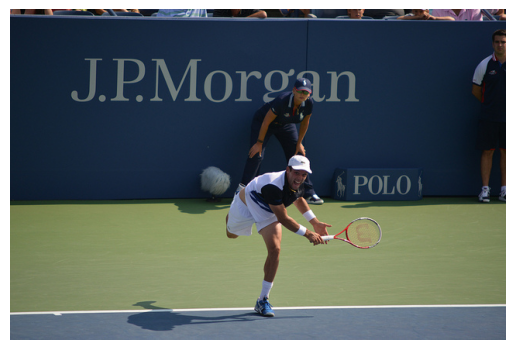


Caption thực tế: A stop sign that is hanging upside down.
Greedy Caption : a tennis player is swinging a tennis racket
Beam Caption   : a tennis player swinging a tennis racket to a tennis


In [34]:
# Đường dẫn ảnh và caption thực tế
image_path = '/kaggle/input/thicuoiki/000000000885.jpg'

# ==== Xử lý ====
features = extract_features(image_path)
greedy_cap = greedy_generator(features)
beam_cap = beam_search_generator(features)

# ==== In kết quả ====
print("\nẢnh:", image_path)
plt.imshow(load_img(image_path))
plt.axis('off')
plt.show()

print("\nCaption thực tế:", actual_caption)
print("Greedy Caption :", greedy_cap)
print("Beam Caption   :", beam_cap)


In [35]:
captions = [
    "a male tennis player in white shorts is playing tennis",
    "This woman has just returned a volley in tennis.",
    "A man holding a tennis racket playing tennis.",
    "The man balances on one leg after serving a tennis ball.",
    "Someone playing in a tennis tournament with a crowd looking on.",
]


print("\nĐánh giá 5 caption thực tế so với caption greedy:\n")
for i, cap in enumerate(captions, 1):
    eval_caption(cap, greedy_cap)


Đánh giá 5 caption thực tế so với caption greedy:



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Similarity: 0.7848


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Similarity: 0.6841


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Similarity: 0.8700


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Similarity: 0.7504


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Similarity: 0.7981


In [36]:
captions = [
    "a male tennis player in white shorts is playing tennis",
    "This woman has just returned a volley in tennis.",
    "A man holding a tennis racket playing tennis.",
    "The man balances on one leg after serving a tennis ball.",
    "Someone playing in a tennis tournament with a crowd looking on.",
]


print("\nĐánh giá 5 caption thực tế so với caption beam:\n")
for i, cap in enumerate(captions, 1):
    eval_caption(cap, beam_cap)


Đánh giá 5 caption thực tế so với caption beam:



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Similarity: 0.7797


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Similarity: 0.7085


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Similarity: 0.8482


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Similarity: 0.7547


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Similarity: 0.7894


# Câu hỏi

Mô hình gồm bao nhiêu khối chức năng (functional blocks)? ví dụ: 2

Khối 1:
* Nhiệm vụ: ví dụ: chuyển ảnh đầu vào thành vector đặc trưng có nghĩa (mục tiêu của khối chức năng tương ứng)
* Vị trí code: ví dụ: cell 10, dòng 30-60 (cell code, dòng code bắt đầu-dòng code kết thúc, tuân theo “line numbers” trên google colab)
* Input: ví dụ: ma trận ảnh (thông tin đầu vào của khối)
* Output: ví dụ: vector đặc trưng (thông tin đầu ra của khối)

Khối 2:
* Nhiệm vụ:
* Vị trí code:
* Input:
* Output:

Khối 3:
* Nhiệm vụ:
* Vị trí code:
* Input:
* Output:

Khối 4:
* Nhiệm vụ:
* Vị trí code:
* Input:
* Output:

…


In [ ]:
!pip install tensorflow==2.12.0  --quiet --upgrade

import os
os.kill(os.getpid(), 9)  # Restart runtime để áp dụng


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 586.0/586.0 MB 2.8 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 1.8 MB/s eta 0:00:000:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 68.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 87.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 98.0 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 31.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.6/79.6 MB 20.8 MB/s eta 0:00:00:00:0100:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
mkl-umath 0.1.1 requires numpy<1.27.0,>=1.26.4, but you have numpy 1.23.5 which is incompatible.
mkl-random 1.2.4 requires numpy<1.27.0,>=1.26.4, but y

In [1]:
import tensorflow as tf
import nltk
#import sacrebleu

print("TensorFlow version:", tf.__version__)
print("NLTK version:", nltk.__version__)
#print("SacreBLEU version:", sacrebleu.__version__)


TensorFlow version: 2.12.0
NLTK version: 3.9.1
